# Credits
Many thanks got to the creators of the super-helpful introductory notebooks, where I took a lot of inspiration and actually copied some parts, as they were too good not to use:

Manav Sehgal https://www.kaggle.com/startupsci/titanic-data-science-solutions

Helge Bjorland https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial

Jeff Delaney https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish

Anisotropic https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [5]:
import os
import itertools

import copy
from tempfile import mkdtemp
from shutil import rmtree

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core import display as ICD

%matplotlib inline

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

# Modelling Helpers
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV, SelectKBest, chi2, RFE, SelectPercentile, f_classif, mutual_info_classif, SelectFromModel
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer 

In [6]:
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore')

In [7]:
import time
start = time.time()

In [8]:
def draw_correlation_map(df):
    correlation = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
            correlation, 
            cmap = cmap,
            square=True, 
            cbar_kws={ 'shrink' : .9 }, 
            ax=ax, 
            annot = True, 
            annot_kws = { 'fontsize' : 8 }
    )

# Load Data

In [9]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "."]).decode("utf8"))
print(check_output(["ls", ".."]).decode("utf8"))

test.csv
train.csv

titanic_prediction.csv
titanic-starter.ipynb

21 - Titanic
22 - House Pricing
input



In [10]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

combined_df = train_df.append(test_df)

del train_df , test_df

# Inspect Data before Transformation

## Dataframe info
The field **age** contains ~20% NULL values. It has to be analyzed, whether the age can be imputed by either a constant value or a good guess. 

**Cabin** only is filled for ~30% of the rows. As there is not enough information it might make no sense to fill up the values.

In [11]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Describe Numeric Values

In [12]:
combined_df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## Describe Non-Numeric Values
**Name** is mostly unique for every person, maybe the extraction of titles might be helpful.

As said before **Cabin** only is filled for ~30% of the rows and might be useless.

The **ticket** indicates whether a group of passengers has booked together and thus might be family.

In [13]:
combined_df.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Kelly, Mr. James",male,CA. 2343
freq,6,914,2,843,11


## A heatmap of correlations of columns with the Survival status

The paid **fare** seems quite a good indicator for survival.

The **PClass** is an anti-correlation (highest is lowest class) is also a good indicator, but the **Pclass** heavily correlates with the **fare** and might be redundant. 

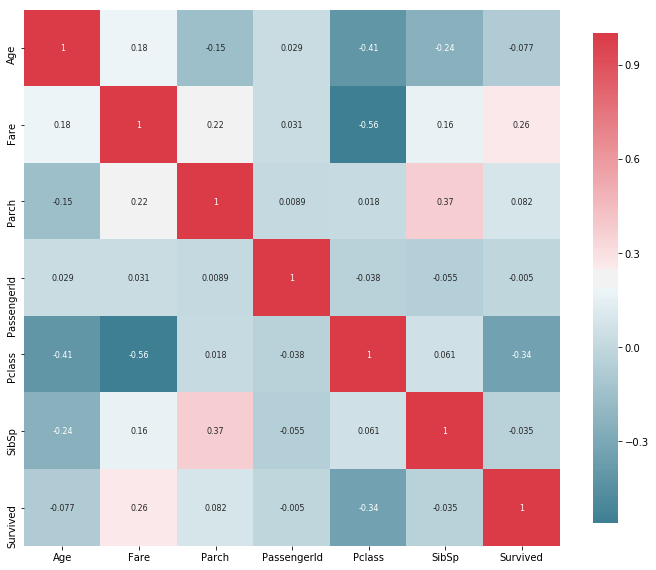

In [14]:
draw_correlation_map(combined_df)

## Correlation of Age and Survival

For **age** one can see there are quite a lot of infants and most passengers are between 18 and 35.

A lot of infants and old people survived, but a lot of the 18-35 range did not.

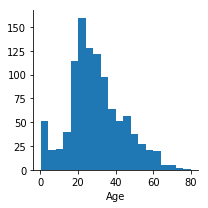

In [15]:
g = sns.FacetGrid(combined_df)
g.map(plt.hist, 'Age', bins=20)

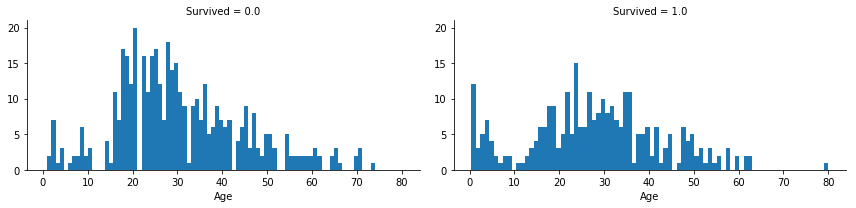

In [38]:
g = sns.FacetGrid(combined_df, col='Survived', aspect=2)
g.map(plt.hist, 'Age', bins=80)
#0-5
#5-13
#15-

## Correlation of Fare and PClass
Maybe there is a direct correlation Fare and PClass and thus the chance of survival.

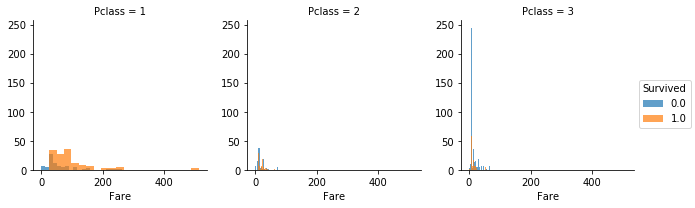

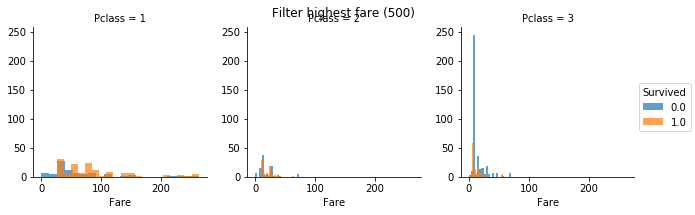

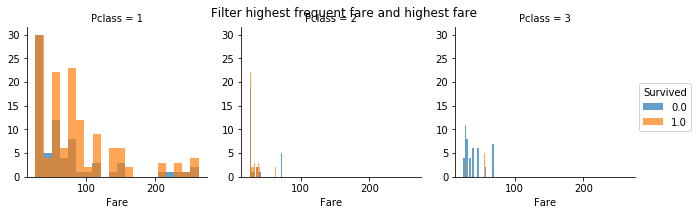

In [17]:
g = sns.FacetGrid(combined_df, col='Pclass', hue='Survived')
g.map(plt.hist, 'Fare', bins=20, alpha=.7)
g.add_legend()

g = sns.FacetGrid(combined_df[(combined_df.Fare < 400)], col='Pclass', hue='Survived')
g.map(plt.hist, 'Fare', bins=20, alpha=.7)
g.fig.suptitle("Filter highest fare (500)")
g.add_legend()

g = sns.FacetGrid(combined_df[(combined_df.Fare < 400) & (combined_df.Fare > 25)], col='Pclass', hue='Survived')
g.map(plt.hist, 'Fare', bins=20, alpha=.7)
g.fig.suptitle("Filter highest frequent fare and highest fare")
g.add_legend()

# Easy Transformations

## Sex - Transform

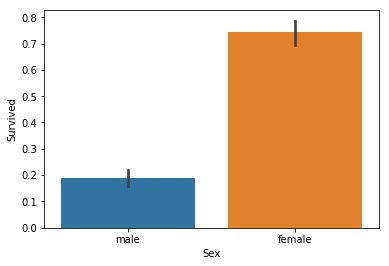

In [19]:
sex = pd.DataFrame()
sex['Sex'] = combined_df.Sex.map( {'female': 1, 'male': 0} ).astype(int)
sns.barplot(x="Sex", y="Survived", data=combined_df)

## Fare - Fill and categorization
Fill only 1 cell.

In [18]:
logical_fare_bins = (-1, 0, 8, 15, 31, 1000)

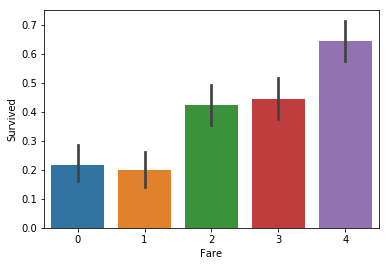

In [20]:
fare = pd.DataFrame()
fare['Survived'] = combined_df.Survived
fare['Pclass'] = combined_df.Pclass
fare['Fare'] = pd.qcut(combined_df.Fare.fillna( combined_df.Fare.mean() ), 5, labels=False)
fare[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Fare', ascending=True)
sns.barplot(x="Fare", y="Survived", data=fare)

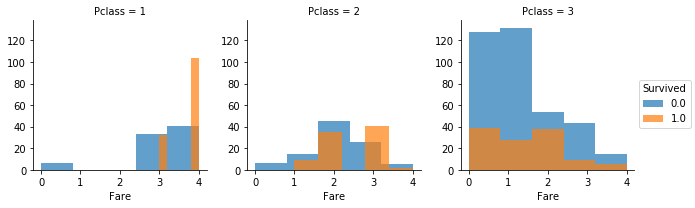

In [21]:
g = sns.FacetGrid(fare, col='Pclass', hue='Survived')
g.map(plt.hist, 'Fare', bins=5, alpha=.7)
g.add_legend()

## Embarked - categorization

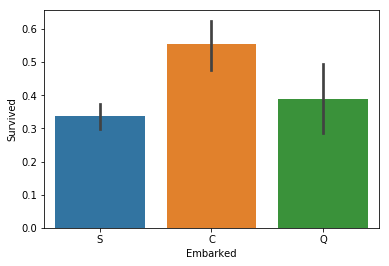

In [22]:
sns.barplot(x="Embarked", y="Survived", data=combined_df)
embarked = pd.get_dummies( combined_df.Embarked , prefix='Embarked' )       

## PClass - categorization

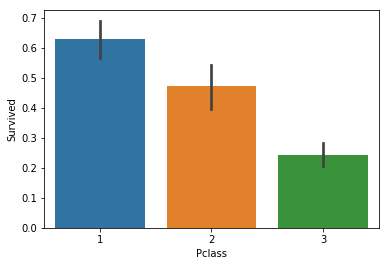

In [23]:
sns.barplot(x="Pclass", y="Survived", data=combined_df)
pclass = pd.get_dummies( combined_df.Pclass , prefix='Pclass' )

# Inspect Transformations

## Age - Inspect fill up and categorization

As we have already seen that there is some correlation between age and the chance of survival, let's try and categorize it.

Also we will have to fill the gaps, with meaningful values.

In [31]:
# Age_Categorized_Mean
def age_binning(logical_age_bins, logical_age_group_names):
    age = pd.DataFrame()
    age['Age'] = combined_df.Age
    age['Survived'] = combined_df.Survived
    age['Sex'] = sex['Sex']
    age['Pclass'] = combined_df['Pclass']


    age['Age_Categorized_Mean'] = pd.cut(age.Age.fillna( age.Age.mean() ), logical_age_bins, labels=logical_age_group_names)
    age_mean = age[['Age_Categorized_Mean', 'Survived']].groupby(['Age_Categorized_Mean'], as_index=False).mean().sort_values(by='Age_Categorized_Mean', ascending=True)
    age_mean = age_mean.rename(columns={'Age_Categorized_Mean': 'Age_Categorized'})
    age_mean['fill_up_type'] = 'mean'

    # Age_Categorized_Unknowns
    age['Age_Categorized_Unknowns'] = pd.cut(age.Age.fillna( -0.5 ), logical_age_bins, labels=logical_age_group_names)
    age_unknown = age[['Age_Categorized_Unknowns', 'Survived']].groupby(['Age_Categorized_Unknowns'], as_index=False).mean().sort_values(by='Age_Categorized_Unknowns', ascending=True)
    age_unknown = age_unknown.rename(columns={'Age_Categorized_Unknowns': 'Age_Categorized'})
    age_unknown['fill_up_type'] = 'unknowns'

    # Age_Categorized_Guess
    age['Age_Guess'] = combined_df.Age
    guess_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = age[(age['Sex'] == i) & (age['Pclass'] == j+1)]['Age'].dropna()
            guess_ages[i,j] = int( guess_df.median()/0.5 + 0.5 ) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
            age.loc[ (age.Age_Guess.isnull()) & (age.Sex == i) & (age.Pclass == j+1), 'Age_Guess'] = guess_ages[i,j]

    age['Age_Categorized_Guess'] = pd.cut(age['Age_Guess'], logical_age_bins, labels=logical_age_group_names)
    age_guess = age[['Age_Categorized_Guess', 'Survived']].groupby(['Age_Categorized_Guess'], as_index=False).mean().sort_values(by='Age_Categorized_Guess', ascending=True)
    age_guess = age_guess.rename(columns={'Age_Categorized_Guess': 'Age_Categorized'})
    age_guess['fill_up_type'] = 'guess'

    age = pd.get_dummies( age.Age_Categorized_Guess , prefix='Age_Categorized_Guess' )

    return (age, age_guess, age_mean, age_unknown)

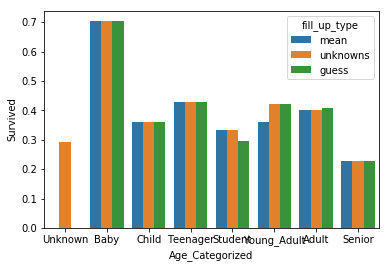

In [32]:
logical_age_bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
logical_age_group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young_Adult', 'Adult', 'Senior']
(age, age_guess, age_mean, age_unknown) = age_binning(logical_age_bins, logical_age_group_names)

age_all = age_mean.append(age_unknown).append(age_guess)
sns.barplot(x="Age_Categorized", y="Survived", hue='fill_up_type', data=age_all)

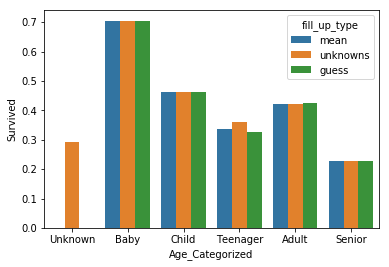

In [34]:
logical_age_bins = (-1, 0, 5, 15, 30, 60, 120)
logical_age_group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Adult', 'Senior']
(age, age_guess, age_mean, age_unknown) = age_binning(logical_age_bins, logical_age_group_names)

age_all = age_mean.append(age_unknown).append(age_guess)
sns.barplot(x="Age_Categorized", y="Survived", hue='fill_up_type', data=age_all)

# Transform Data

##  Name - Extraction of title and clean up

In [22]:
titles = combined_df[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip()).unique()
for title in titles:
    print(title, sep=', ', end=', ')

Mr, Mrs, Miss, Master, Don, Rev, Dr, Mme, Ms, Major, Lady, Sir, Mlle, Col, Capt, the Countess, Jonkheer, Dona, 

In [23]:
title = pd.DataFrame()

title[ 'Title' ] = combined_df[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title['Survived'] = combined_df.Survived
title['Sex'] = sex.Sex

title
There are several insights from using the **title** as a feature, e.g. the survival rate of Master is higher than a normal Mr. 

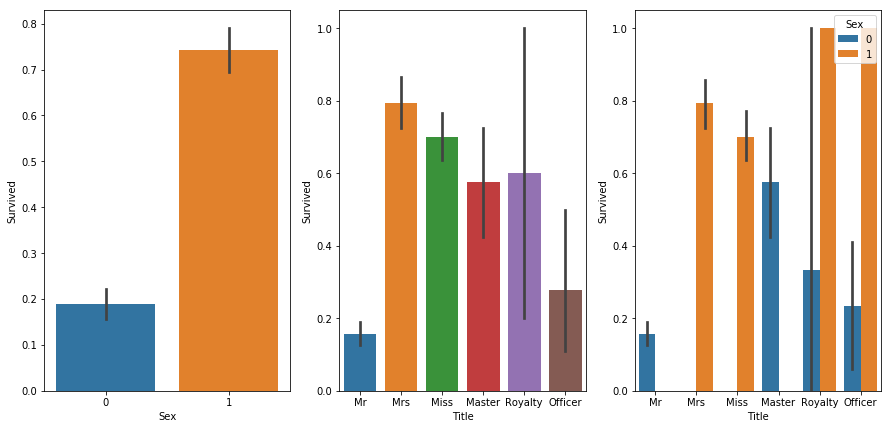

In [24]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)

sns.barplot(x="Sex", y="Survived", data=title, ax=ax[0])
sns.barplot(x="Title", y="Survived", data=title, ax=ax[1])
sns.barplot(x="Title", y="Survived", hue='Sex', data=title, ax=ax[2])

title = pd.get_dummies( title.Title, prefix='Title')

##  Cabin - Extraction of title and clean up

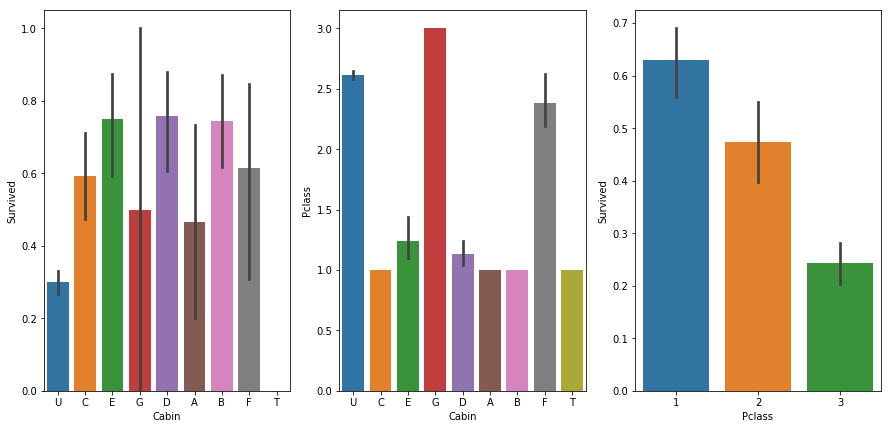

In [25]:
cabin = pd.DataFrame()
cabin['Survived'] = combined_df.Survived
cabin['Pclass'] = combined_df.Pclass
cabin['Cabin'] = combined_df.Cabin.fillna( 'U' )
cabin['Cabin'] = cabin['Cabin'].map( lambda c : c[0] )

fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
sns.barplot(x="Cabin", y="Survived", data=cabin, ax=ax[0])
sns.barplot(x="Cabin", y="Pclass", data=cabin, ax=ax[1])
sns.barplot(x="Pclass", y="Survived", data=cabin, ax=ax[2])

cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

##  Ticket - Extraction of title and clean up

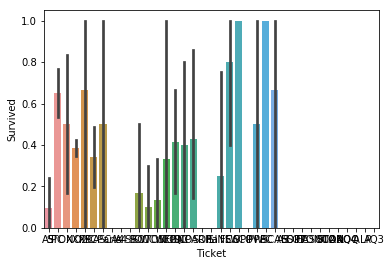

In [26]:
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()
ticket['Ticket'] = combined_df[ 'Ticket' ].map( cleanTicket )
ticket['Survived'] = combined_df.Survived
ticket['Pclass'] = combined_df.Pclass

sns.barplot(x="Ticket", y="Survived", data=ticket)

ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

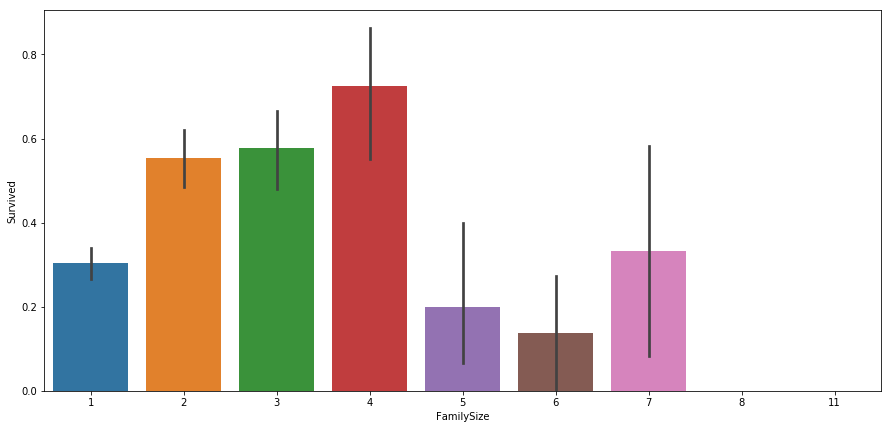

In [27]:
family = pd.DataFrame()
family[ 'FamilySize' ] = combined_df[ 'Parch' ] + combined_df[ 'SibSp' ] + 1

family['Survived'] = combined_df.Survived

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x="FamilySize", y="Survived", data=family, ax=ax)
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

## Concat transformed data into new dataframe

In [28]:
transformed_df = pd.DataFrame()

transformed_df['Survived'] = combined_df.Survived
transformed_df['Sex'] = sex.Sex
transformed_df['Fare'] = fare.Fare
transformed_df['Cabin_U'] = cabin.Cabin_U
transformed_df['Cabin_C'] = cabin.Cabin_C
transformed_df['Cabin_E'] = cabin.Cabin_E
transformed_df['Cabin_G'] = cabin.Cabin_G
transformed_df['Cabin_D'] = cabin.Cabin_D
transformed_df['Cabin_A'] = cabin.Cabin_A
transformed_df['Cabin_B'] = cabin.Cabin_B
transformed_df['Cabin_F'] = cabin.Cabin_F
transformed_df['Cabin_T'] = cabin.Cabin_T
transformed_df['Embarked_S'] = embarked.Embarked_S
transformed_df['Embarked_C'] = embarked.Embarked_C
transformed_df['Embarked_Q'] = embarked.Embarked_Q
transformed_df['Pclass_1'] = pclass.Pclass_1
transformed_df['Pclass_2'] = pclass.Pclass_2
transformed_df['Pclass_3'] = pclass.Pclass_3
transformed_df['Age_Categorized_Baby'] = age.Age_Categorized_Guess_Baby    
transformed_df['Age_Categorized_Child'] = age.Age_Categorized_Guess_Child   
transformed_df['Age_Categorized_Teenager'] = age.Age_Categorized_Guess_Teenager    
transformed_df['Age_Categorized_Student'] = age.Age_Categorized_Guess_Student     
transformed_df['Age_Categorized_Young_Adult'] = age.Age_Categorized_Guess_Young_Adult
transformed_df['Age_Categorized_Adult'] = age.Age_Categorized_Guess_Adult   
transformed_df['Age_Categorized_Senior'] = age.Age_Categorized_Guess_Senior
transformed_df['Title_Mr'] = title.Title_Mr
transformed_df['Title_Mrs'] = title.Title_Mrs
transformed_df['Title_Miss'] = title.Title_Miss
transformed_df['Title_Master'] = title.Title_Master
transformed_df['Title_Royalty'] = title.Title_Royalty
transformed_df['Title_Officer'] = title.Title_Officer
transformed_df['Family_Single'] = family.Family_Single
transformed_df['Family_Small'] = family.Family_Small
transformed_df['Family_Large'] = family.Family_Large



# Inspect Data

In [29]:
transformed_df.head()

,Survived,Sex,Fare,Cabin_U,Cabin_C,Cabin_E,Cabin_G,Cabin_D,Cabin_A,Cabin_B,...,Age_Categorized_Senior,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Title_Royalty,Title_Officer,Family_Single,Family_Small,Family_Large
0,0.0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1.0,1,4,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.0,1,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1.0,1,4,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [30]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 34 columns):
Survived                       891 non-null float64
Sex                            1309 non-null int64
Fare                           1309 non-null int64
Cabin_U                        1309 non-null uint8
Cabin_C                        1309 non-null uint8
Cabin_E                        1309 non-null uint8
Cabin_G                        1309 non-null uint8
Cabin_D                        1309 non-null uint8
Cabin_A                        1309 non-null uint8
Cabin_B                        1309 non-null uint8
Cabin_F                        1309 non-null uint8
Cabin_T                        1309 non-null uint8
Embarked_S                     1309 non-null uint8
Embarked_C                     1309 non-null uint8
Embarked_Q                     1309 non-null uint8
Pclass_1                       1309 non-null uint8
Pclass_2                       1309 non-null uint8
Pclass_3                  

In [31]:
transformed_df.describe()

,Survived,Sex,Fare,Cabin_U,Cabin_C,Cabin_E,Cabin_G,Cabin_D,Cabin_A,Cabin_B,...,Age_Categorized_Senior,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Title_Royalty,Title_Officer,Family_Single,Family_Small,Family_Large
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,0.355997,1.982429,0.774637,0.071811,0.031322,0.003820,0.035141,0.016807,0.049656,...,0.025210,0.578304,0.152788,0.200153,0.046600,0.004584,0.017571,0.603514,0.333843,0.062643
std,0.486592,0.478997,1.424071,0.417981,0.258273,0.174252,0.061709,0.184207,0.128596,0.217317,...,0.156823,0.494019,0.359921,0.400267,0.210862,0.067573,0.131435,0.489354,0.471765,0.242413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Dataset Split into Train and Test

In [32]:
train_X = transformed_df[ 0:891 ]
train_y = train_X.Survived
train_X = train_X.drop([
    'Survived',
], axis=1)

train_X, evaluate_X, train_y, evaluate_y = train_test_split(train_X, train_y, random_state=0)

test_X = transformed_df[ 891: ]
test_X = test_X.drop(['Survived'], axis=1)

print(train_X.shape, train_y.shape, evaluate_X.shape, evaluate_y.shape, test_X.shape)

(668, 33) (668,) (223, 33) (223,) (418, 33)


# Models

In [33]:
fits = {}
models = {}
scores = {}
evaluation = {}
feature_selections = {}

cache_dirs = []

In [34]:
n_jobs = -1
scorings = ["recall", "precision", "accuracy", "f1"]
scoring_refit = "recall"

grid_search_parameters = {
    'scoring': scorings, 
    'n_jobs': n_jobs, 
    'verbose': 1, 
    'refit': scoring_refit,
    'return_train_score': True,
    'error_score': 0
}

In [35]:
def print_features(reduce_dim):
    print('print_features')
    if type(reduce_dim).__name__ == 'SelectKBest':
        feature_scores = ['%.2f' % elem for elem in reduce_dim.scores_ ]
    else:
        feature_scores = np.zeros(len(train_X.columns))
    #feature_scores_pvalues = ['%.3f' % elem for elem in  reduce_dim.pvalues_ ]

    #features_selected_tuple=[(train_X.columns[i+1], feature_scores[i], feature_scores_pvalues[i]) for i in reduce_dim.get_support(indices=True)]
    features_selected_tuple=[(train_X.columns[i], feature_scores[i]) for i in reduce_dim.get_support(indices=True)]
    features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

    print(features_selected_tuple)
    return features_selected_tuple

In [36]:
def print_rfecv_features(reduce_dim):
    feature_scores = ['%.2f' % elem for elem in reduce_dim.grid_scores_ ]
    #feature_scores_pvalues = ['%.3f' % elem for elem in  reduce_dim.pvalues_ ]

    #features_selected_tuple=[(train_X.columns[i+1], feature_scores[i], feature_scores_pvalues[i]) for i in reduce_dim.get_support(indices=True)]
    features_selected_tuple=[(train_X.columns[i+1], feature_scores[i]) for i in reduce_dim.get_support(indices=True)]
    features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

    print(features_selected_tuple)
    return features_selected_tuple

In [37]:
def evaluate_model(model, cv_X, cv_y):
    return cross_validate(
        clone(model), 
        cv_X, 
        cv_y, 
        scoring=scorings, 
        n_jobs=n_jobs, 
        return_train_score=True
    )

In [38]:
def plot_rfecv(model):
    print("Optimal number of features : %d" % model.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(model.grid_scores_) + 1), model.grid_scores_)
    plt.show()

In [39]:
def show_group_evaluation(evaluation, model_group, limit=5, max_per_group=False):
    evaluation_stats = []
    for model in evaluation:
        if model.startswith(model_group):
            evaluation_stat = {}
            evaluation_stat['group'] = model.split('-')[0]
            evaluation_stat['type'] = model    
            for scoring in scorings:
                for sample in ['test', 'train']:#['train', 'test']:
                    evaluation_stat[sample + '_' + scoring + '_mean'] = np.array(evaluation[model][sample + '_' + scoring]).mean()
                    evaluation_stat[sample + '_' + scoring + '_std'] = np.array(evaluation[model][sample + '_' + scoring]).std()
            evaluation_stats.append(evaluation_stat)
    evaluation_stats = pd.DataFrame(evaluation_stats)
    for scoring in scorings:
        evaluation_stats_sorted = evaluation_stats.sort_values(['test' + '_' + scoring + '_mean', 'test' + '_' + scoring + '_std'], ascending=[False, True])
        if max_per_group:
            evaluation_stats_sorted = evaluation_stats_sorted.groupby('group', as_index=False).first()
            evaluation_stats_sorted = evaluation_stats_sorted.sort_values(['test' + '_' + scoring + '_mean', 'test' + '_' + scoring + '_std'], ascending=[False, True])
        ICD.display(evaluation_stats_sorted[['group', 'type', 'test' + '_' + scoring + '_mean', 'test' + '_' + scoring + '_std', 'train' + '_' + scoring + '_mean', 'train' + '_' + scoring + '_std']].head(limit))

In [40]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def show_search(search):
    columns = set([param for param in search.cv_results_['params'][0]])
    
    data = pd.DataFrame(search.cv_results_)
    data_spliced = data[['param_%s' % column for column in columns] + ['mean_test_accuracy', 'std_test_accuracy', 'mean_train_accuracy', 'std_train_accuracy', 'mean_test_precision', 'std_test_precision', 'mean_test_recall', 'std_test_recall']]
    data_spliced.columns = [column.replace('classify__', '').replace('reduce_dim__', '') for column in columns] + ['acc', '+/-acc', 'tr-acc', 'tr+/-acc', 'prec', '+/-prec', 'rec', '+/-rec']
    data_sorted = data_spliced.sort_values(['rec', '+/-rec'], ascending=[False, True])
    data_rounded = np.round(data_sorted, 4)
    print(data_rounded.head(10))

In [41]:
def show_scores(scores, model_name, limit=5):
    tmp = []
    for model in scores:
        if model.startswith(model_name):
            tmp.append([model, scores[model][0], scores[model][1]])
    tmp = pd.DataFrame(tmp)
    tmp.columns = ['model_name', 'train', 'test']
    tmp_sorted = tmp.sort_values(['test'], ascending=[False])
    ICD.display(tmp_sorted.head(limit))

In [42]:
def clean_cache_dirs(cache_dirs):
    for cache_dir in cache_dirs:
        if os.path.exists(cache_dir):
            rmtree(cache_dir)
    cache_dirs = []

In [43]:
def build_pipelline(base_model, pipeline, param_grid, reduce_dim_param_grid, grid_search_parameters, cache_dirs):
    param_grid = [{'classify__'+key: value for (key, value) in inner_param_grid.items()} for inner_param_grid in param_grid]
    if type(param_grid) == list:
        for i in range(len(param_grid)):
            for key, value in reduce_dim_param_grid.items():
                param_grid[i][key] = value
    if type(param_grid) == dict:
        for key, value in reduce_dim_param_grid.items():
            param_grid[key] = value
    cachedir = mkdtemp()
    cache_dirs.append(cachedir)
    memory = Memory(cachedir=cachedir, verbose=0)
    pipe = Pipeline(pipeline, memory=memory)
    gridsearch = GridSearchCV(
        pipe, 
        param_grid = param_grid, 
        **grid_search_parameters
    )
    return gridsearch

def build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs):
    
    reduce_dims = [
        None,
        SelectKBest(chi2),
        SelectPercentile(chi2),
        SelectFromModel(LinearSVC(penalty="l1", dual=False))
    ]
    
    scalers = [
        None,
        MinMaxScaler(),
        RobustScaler(quantile_range=(25, 75)),
        Normalizer()
    ]
    
    experiments = []
    
    for reduce_dim in reduce_dims:
        for scaler in scalers:
            experiment_name = model_name
            pipeline = []            
            if reduce_dim != None:
                pipeline.append(('reduce_dim', reduce_dim))
                experiment_name += type(reduce_dim).__name__
            if scaler != None:
                pipeline.append(('scaler', scaler))
                experiment_name += type(scaler).__name__
            pipeline.append(('classify', clone(base_model)))
            experiment = build_pipelline(
                base_model, 
                pipeline , 
                param_grid, 
                {}, 
                grid_search_parameters, 
                cache_dirs
            )
            experiments.append((experiment_name, experiment))
    
    #if hasattr(base_model, 'coef_') or hasattr(base_model, 'feature_importances_'):
    #    rfecv = RFECV(estimator=clone(base_model), step=1, cv=StratifiedKFold(2), scoring='accuracy')
    #    experiments.append((model_name + '-rfecv', rfecv))
    
    return experiments

In [44]:
def run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs):
    for (model_name, model) in experiments:
        print('Fit', model_name)
        model.fit(train_X , train_y)

        print('model', type(model).__name__)
        if type(model).__name__ == 'GridSearchCV':
            best_model = model.best_estimator_
            print(type(best_model))
            show_search(model)
            if type(best_model).__name__ == 'Pipeline':
                if 'reduce_dim' in best_model.named_steps:
                    reduce_dim = best_model.named_steps['reduce_dim']
                    selected_features = print_features(reduce_dim)
                    feature_selections[model_name] = [
                        selected_features,
                        model.best_score_
                    ]
        elif type(model).__name__ == 'RFECV':
            plot_rfecv(model)
            best_model = model
            selected_features = print_rfecv_features(best_model)
            feature_selections[model_name] = [
                selected_features,
                model.best_score_
            ]
        else:
            best_model = model
        
        print('best_model', type(best_model).__name__)

        models[model_name] = {}
        models[model_name][scoring_refit] = best_model

        evaluation[model_name] = evaluate_model(best_model, evaluate_X, evaluate_y)
        scores[model_name] = (best_model.score(train_X, train_y), best_model.score(evaluate_X, evaluate_y))
    clean_cache_dirs(cache_dirs)

## Model Parameter Search

### RandomForestClassifier

In [45]:
#reduced_X = 
#reduce_dim = models['RandomForestClassifier'][scoring_refit].named_steps['reduce_dim']
#reduced_X = pd.DataFrame(reduce_dim.transform(train_X), columns=train_X.columns[reduce_dim.get_support()])
#best_model = models['RandomForestClassifier'][scoring_refit].named_steps['classify']

model_name = 'RandomForestClassifier'
base_model = RandomForestClassifier(random_state=0)

param_grid = [
    {
        "max_features" : ['sqrt', 'log2'],
        "max_depth": [None, 1, 5, 10, 100],
        "n_estimators" :[10, 100, 1000],
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit RandomForestClassifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
13         sqrt          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
16         log2          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
14         sqrt         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
17         log2         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
12         sqrt           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
15         log2           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
0          sqrt           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094  0.0475
3          log2           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
13         sqrt          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
16         log2          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
14         sqrt         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
17         log2         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
12         sqrt           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
15         log2           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
0          sqrt           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094  0.0475
3          log2           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.8s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
13         sqrt          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
16         log2          100         5  0.8263  0.0018  0.8548    0.0010  0.8207   0.0490  0.7133  0.0572
14         sqrt         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
17         log2         1000         5  0.8278  0.0039  0.8555    0.0011  0.8234   0.0477  0.7133  0.0478
12         sqrt           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
15         log2           10         5  0.8308  0.0074  0.8473    0.0083  0.8368   0.0613  0.7094  0.0528
0          sqrt           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094  0.0475
3          log2           10      None  0.7919  0.0083  0.9184    0.0065  0.7455   0.0387  0.7094

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   14.1s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12         sqrt           10         5  0.8234  0.0089  0.8540    0.0063  0.8000   0.0389  0.7287  0.0384
15         log2           10         5  0.8234  0.0089  0.8540    0.0063  0.8000   0.0389  0.7287  0.0384
2          sqrt         1000      None  0.8114  0.0101  0.9236    0.0080  0.7858   0.0280  0.7095  0.0741
5          log2         1000      None  0.8114  0.0101  0.9236    0.0080  0.7858   0.0280  0.7095  0.0741
20         sqrt         1000        10  0.8114  0.0077  0.9207    0.0094  0.7872   0.0366  0.7095  0.0741
23         log2         1000        10  0.8114  0.0077  0.9207    0.0094  0.7872   0.0366  0.7095  0.0741
26         sqrt         1000       100  0.8114  0.0101  0.9236    0.0080  0.7858   0.0280  0.7095  0.0741
29         log2         1000       100  0.8114  0.0101  0.9236    0.0080  0.7858   0.0280  0.7095

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.8s finished


Fit RandomForestClassifierSelectKBest
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
9          log2           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
12         sqrt           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
15         log2           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
13         sqrt          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
16         log2          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
14         sqrt         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978  0.0684
17         log2         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
9          log2           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
12         sqrt           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
15         log2           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
13         sqrt          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
16         log2          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
14         sqrt         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978  0.0684
17         log2         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   15.7s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
9          log2           10         1  0.7904  0.0207  0.7904    0.0104  0.7176   0.0399  0.7597  0.0145
12         sqrt           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
15         log2           10         5  0.8234  0.0053  0.8473    0.0047  0.8128   0.0478  0.7133  0.0478
13         sqrt          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
16         log2          100         5  0.8234  0.0020  0.8503    0.0054  0.8147   0.0418  0.7094  0.0528
14         sqrt         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978  0.0684
17         log2         1000         5  0.8204  0.0040  0.8511    0.0045  0.8175   0.0457  0.6978

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   31.0s finished


Fit RandomForestClassifierSelectKBestNormalizer
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   15.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt           10         1  0.7919  0.0261  0.7942    0.0067  0.7169   0.0439  0.7674  0.0165
9          log2           10         1  0.7919  0.0261  0.7942    0.0067  0.7169   0.0439  0.7674  0.0165
12         sqrt           10         5  0.8204  0.0073  0.8518    0.0072  0.8190   0.0549  0.6978  0.0684
15         log2           10         5  0.8204  0.0073  0.8518    0.0072  0.8190   0.0549  0.6978  0.0684
13         sqrt          100         5  0.8114  0.0040  0.8548    0.0063  0.8144   0.0540  0.6746  0.0741
16         log2          100         5  0.8114  0.0040  0.8548    0.0063  0.8144   0.0540  0.6746  0.0741
1          sqrt          100      None  0.8039  0.0116  0.8593    0.0037  0.7898   0.0212  0.6746  0.0664
4          log2          100      None  0.8039  0.0116  0.8593    0.0037  0.7898   0.0212  0.6746

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.8s finished


Fit RandomForestClassifierSelectPercentile
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.9s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0          sqrt           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
1          sqrt          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
3          log2           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
4          log2          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
12         sqrt           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
13         sqrt          100         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
14         sqrt         1000         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
15         log2           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.0s finished


Fit RandomForestClassifierSelectPercentileMinMaxScaler
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0          sqrt           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
1          sqrt          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
3          log2           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
4          log2          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
12         sqrt           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
13         sqrt          100         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
14         sqrt         1000         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
15         log2           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.6s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0          sqrt           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
1          sqrt          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
3          log2           10      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
4          log2          100      None  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
12         sqrt           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
13         sqrt          100         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
14         sqrt         1000         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
15         log2           10         5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.1s finished


Fit RandomForestClassifierSelectPercentileNormalizer
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
14         sqrt         1000         5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
17         log2         1000         5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
2          sqrt         1000      None  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249  0.0478
5          log2         1000      None  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249  0.0478
20         sqrt         1000        10  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249  0.0478
23         log2         1000        10  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249  0.0478
26         sqrt         1000       100  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249  0.0478
29         log2         1000       100  0.7844  0.0155  0.7919    0.0082  0.7262   0.0542  0.7249

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
14         sqrt         1000         5  0.8308  0.0145  0.8593    0.0046  0.8167   0.0562  0.7326  0.0285
17         log2         1000         5  0.8308  0.0145  0.8593    0.0046  0.8167   0.0562  0.7326  0.0285
13         sqrt          100         5  0.8263  0.0114  0.8600    0.0046  0.8108   0.0497  0.7249  0.0333
16         log2          100         5  0.8263  0.0114  0.8600    0.0046  0.8108   0.0497  0.7249  0.0333
20         sqrt         1000        10  0.8144  0.0077  0.9162    0.0112  0.7854   0.0345  0.7211  0.0593
23         log2         1000        10  0.8144  0.0077  0.9162    0.0112  0.7854   0.0345  0.7211  0.0593
19         sqrt          100        10  0.8114  0.0066  0.9162    0.0112  0.7817   0.0356  0.7172  0.0632
22         log2          100        10  0.8114  0.0066  0.9162    0.0112  0.7817   0.0356  0.7172

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
14         sqrt         1000         5  0.8308  0.0149  0.8585    0.0018  0.8188   0.0542  0.7287  0.0290
17         log2         1000         5  0.8308  0.0149  0.8585    0.0018  0.8188   0.0542  0.7287  0.0290
20         sqrt         1000        10  0.8174  0.0087  0.9162    0.0094  0.7893   0.0325  0.7249  0.0610
23         log2         1000        10  0.8174  0.0087  0.9162    0.0094  0.7893   0.0325  0.7249  0.0610
13         sqrt          100         5  0.8263  0.0114  0.8623    0.0038  0.8108   0.0497  0.7249  0.0333
16         log2          100         5  0.8263  0.0114  0.8623    0.0038  0.8108   0.0497  0.7249  0.0333
2          sqrt         1000      None  0.8159  0.0077  0.9199    0.0118  0.7951   0.0272  0.7094  0.0577
5          log2         1000      None  0.8159  0.0077  0.9199    0.0118  0.7951   0.0272  0.7094

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   33.7s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
14         sqrt         1000         5  0.8308  0.0145  0.8593    0.0046  0.8167   0.0562  0.7326  0.0285
17         log2         1000         5  0.8308  0.0145  0.8593    0.0046  0.8167   0.0562  0.7326  0.0285
13         sqrt          100         5  0.8263  0.0114  0.8600    0.0046  0.8108   0.0497  0.7249  0.0333
16         log2          100         5  0.8263  0.0114  0.8600    0.0046  0.8108   0.0497  0.7249  0.0333
20         sqrt         1000        10  0.8144  0.0077  0.9162    0.0112  0.7854   0.0345  0.7211  0.0593
23         log2         1000        10  0.8144  0.0077  0.9162    0.0112  0.7854   0.0345  0.7211  0.0593
19         sqrt          100        10  0.8114  0.0066  0.9162    0.0112  0.7817   0.0356  0.7172  0.0632
22         log2          100        10  0.8114  0.0066  0.9162    0.0112  0.7817   0.0356  0.7172

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.8s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
18         sqrt           10        10  0.8024  0.0110  0.9109    0.0118  0.7599   0.0254  0.7171  0.0428
21         log2           10        10  0.8024  0.0110  0.9109    0.0118  0.7599   0.0254  0.7171  0.0428
19         sqrt          100        10  0.8024  0.0062  0.9162    0.0143  0.7701   0.0432  0.7055  0.0556
22         log2          100        10  0.8024  0.0062  0.9162    0.0143  0.7701   0.0432  0.7055  0.0556
14         sqrt         1000         5  0.8219  0.0081  0.8690    0.0011  0.8145   0.0485  0.7055  0.0449
17         log2         1000         5  0.8219  0.0081  0.8690    0.0011  0.8145   0.0485  0.7055  0.0449
1          sqrt          100      None  0.8009  0.0108  0.9192    0.0129  0.7681   0.0349  0.7017  0.0686
4          log2          100      None  0.8009  0.0108  0.9192    0.0129  0.7681   0.0349  0.7017

In [46]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
3,RandomForestClassifierSelectKBestNormalizer,RandomForestClassifierSelectKBestNormalizer,0.738095,0.067344,0.821429,0.029161
10,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.690476,0.073386,0.851190,0.058926
2,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.678571,0.077152,0.857143,0.050508
8,RandomForestClassifierNormalizer,RandomForestClassifierNormalizer,0.666667,0.044544,0.875000,0.050508
11,RandomForestClassifierSelectFromModelRobustScaler,RandomForestClassifierSelectFromModelRobustScaler,0.666667,0.044544,0.857143,0.063554


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
10,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.787778,0.116757,0.917049,0.020689
2,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.771111,0.093703,0.911404,0.022717
11,RandomForestClassifierSelectFromModelRobustScaler,RandomForestClassifierSelectFromModelRobustScaler,0.765556,0.130535,0.917398,0.021135
4,RandomForestClassifierMinMaxScaler,RandomForestClassifierMinMaxScaler,0.760000,0.099331,0.924178,0.011270
12,RandomForestClassifier,RandomForestClassifier,0.760000,0.099331,0.924178,0.011270


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
10,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.806907,0.050463,0.914732,0.022484
2,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.798018,0.040523,0.914732,0.022484
4,RandomForestClassifierMinMaxScaler,RandomForestClassifierMinMaxScaler,0.789009,0.039673,0.921473,0.017045
12,RandomForestClassifier,RandomForestClassifier,0.789009,0.039673,0.921473,0.017045
15,RandomForestClassifierRobustScaler,RandomForestClassifierRobustScaler,0.789009,0.039673,0.921473,0.017045


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
10,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.730599,0.064424,0.881747,0.034577
2,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.716710,0.053291,0.882795,0.033161
11,RandomForestClassifierSelectFromModelRobustScaler,RandomForestClassifierSelectFromModelRobustScaler,0.707610,0.062602,0.885027,0.038094
4,RandomForestClassifierMinMaxScaler,RandomForestClassifierMinMaxScaler,0.705216,0.046268,0.891396,0.027196
12,RandomForestClassifier,RandomForestClassifier,0.705216,0.046268,0.891396,0.027196


In [47]:
show_scores(scores, model_name)

,model_name,train,test
2,RandomForestClassifierSelectFromModelMinMaxScaler,0.844311,0.829596
10,RandomForestClassifierSelectFromModel,0.844311,0.825112
11,RandomForestClassifierSelectFromModelRobustScaler,0.844311,0.825112
4,RandomForestClassifierMinMaxScaler,0.842814,0.820628
12,RandomForestClassifier,0.842814,0.820628



### C-Support Vector Classification

In [48]:
model_name = 'SVC'
base_model = SVC(probability=True, random_state=0)

param_grid = [{
    'kernel': ['rbf', 'linear'], 
    'gamma': ['auto', 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013],
    'C': [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.5, 0.9, 1, 1.5, 2 , 3, 4]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [49]:
#show_group_evaluation(evaluation, model_name)

In [50]:
#show_scores(scores, model_name)

### GradientBoostingClassifier

In [51]:
model_name = 'GradientBoostingClassifier'
base_model =  GradientBoostingClassifier(random_state=0, loss='deviance')

param_grid = [{
    'loss' : ['deviance', 'exponential'],
    'n_estimators' : [50, 100, 150],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [2, 3, 5, 6],
    'min_samples_leaf': [5, 10],
    'max_features' : [None, 'auto', 'log2']
}]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit GradientBoostingClassifier
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 982 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0           None           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
6           auto           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
86          log2          150         2          0.05  exponential                5  0.8323  0.0199  0.8473    0.0072  0.8043   0.0587  0.7558  0.0164
144         None           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
150         auto           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
216         None           50         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 749 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.3min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0           None           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
6           auto           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
86          log2          150         2          0.05  exponential                5  0.8323  0.0199  0.8473    0.0072  0.8043   0.0587  0.7558  0.0164
144         None           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
150         auto           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
216         None           50         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.1min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0           None           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
6           auto           50         2          0.05     deviance                5  0.8368  0.0166  0.8413    0.0131  0.8133   0.0522  0.7558  0.0164
86          log2          150         2          0.05  exponential                5  0.8323  0.0199  0.8473    0.0072  0.8043   0.0587  0.7558  0.0164
144         None           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
150         auto           50         2         0.075     deviance                5  0.8353  0.0178  0.8481    0.0100  0.8103   0.0545  0.7558  0.0164
216         None           50         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
1           None          100         2          0.05     deviance                5  0.8323  0.0135  0.8600    0.0009  0.8129   0.0670  0.7482  0.0438
7           auto          100         2          0.05     deviance                5  0.8323  0.0135  0.8600    0.0009  0.8129   0.0670  0.7482  0.0438
73          None          100         2          0.05  exponential                5  0.8323  0.0166  0.8593    0.0020  0.8125   0.0682  0.7481  0.0359
79          auto          100         2          0.05  exponential                5  0.8323  0.0166  0.8593    0.0020  0.8125   0.0682  0.7481  0.0359
360         None           50         2           0.1  exponential                5  0.8323  0.0170  0.8593    0.0010  0.8125   0.0683  0.7481  0.0359
366         auto           50         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
228         log2           50         2         0.075  exponential                5  0.8084  0.0181  0.8151    0.0055  0.7661   0.0484  0.7326  0.0342
89          log2          150         2          0.05  exponential               10  0.8189  0.0108  0.8308    0.0104  0.7945   0.0505  0.7249  0.0428
1           None          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
2           None          150         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
7           auto          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
8           auto          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
228         log2           50         2         0.075  exponential                5  0.8084  0.0181  0.8151    0.0055  0.7661   0.0484  0.7326  0.0342
89          log2          150         2          0.05  exponential               10  0.8189  0.0108  0.8308    0.0104  0.7945   0.0505  0.7249  0.0428
1           None          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
2           None          150         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
7           auto          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
8           auto          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   53.8s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
228         log2           50         2         0.075  exponential                5  0.8084  0.0181  0.8151    0.0055  0.7661   0.0484  0.7326  0.0342
89          log2          150         2          0.05  exponential               10  0.8189  0.0108  0.8308    0.0104  0.7945   0.0505  0.7249  0.0428
1           None          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
2           None          150         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
7           auto          100         2          0.05     deviance                5  0.8293  0.0094  0.8383    0.0048  0.8172   0.0453  0.7249  0.0333
8           auto          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   47.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
90          None           50         3          0.05  exponential                5  0.8293  0.0187  0.8451    0.0047  0.8073   0.0559  0.7403  0.0198
96          auto           50         3          0.05  exponential                5  0.8293  0.0187  0.8451    0.0047  0.8073   0.0559  0.7403  0.0198
18          None           50         3          0.05     deviance                5  0.8308  0.0177  0.8473    0.0072  0.8123   0.0518  0.7365  0.0145
24          auto           50         3          0.05     deviance                5  0.8308  0.0177  0.8473    0.0072  0.8123   0.0518  0.7365  0.0145
372         log2           50         2           0.1  exponential                5  0.8189  0.0108  0.8353    0.0089  0.7875   0.0406  0.7326  0.0285
231         log2           50         2

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   18.1s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth learning_rate      loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
18         None           50         3          0.05  deviance                5  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
19         None          100         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
20         None          150         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
21         None           50         3          0.05  deviance               10  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
22         None          100         3          0.05  deviance               10  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
23         None          150         3          0.05  deviance 

[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   32.7s finished


Fit GradientBoostingClassifierSelectPercentileMinMaxScaler
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   35.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth learning_rate      loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
18         None           50         3          0.05  deviance                5  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
19         None          100         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
20         None          150         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
21         None           50         3          0.05  deviance               10  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
22         None          100         3          0.05  deviance               10  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
23         None          150         3          0.05  deviance 

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   35.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth learning_rate      loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
18         None           50         3          0.05  deviance                5  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
19         None          100         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
20         None          150         3          0.05  deviance                5  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
21         None           50         3          0.05  deviance               10  0.7829  0.0169  0.7957    0.0118  0.7279   0.0531  0.7133  0.0487
22         None          100         3          0.05  deviance               10  0.7829  0.0169  0.7964    0.0127  0.7279   0.0531  0.7133  0.0487
23         None          150         3          0.05  deviance 

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   34.7s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features n_estimators max_depth learning_rate      loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
1          None          100         2          0.05  deviance                5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
7          auto          100         2          0.05  deviance                5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
12         log2           50         2          0.05  deviance                5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
13         log2          100         2          0.05  deviance                5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
14         log2          150         2          0.05  deviance                5  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
15         log2           50         2          0.05  deviance 

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   53.6s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
17          log2          150         2          0.05     deviance               10  0.8323  0.0199  0.8466    0.0041  0.8004   0.0614  0.7636  0.0219
373         log2          100         2           0.1  exponential                5  0.8338  0.0124  0.8503    0.0068  0.8010   0.0438  0.7636  0.0219
86          log2          150         2          0.05  exponential                5  0.8353  0.0241  0.8481    0.0085  0.8071   0.0668  0.7636  0.0145
229         log2          100         2         0.075  exponential                5  0.8338  0.0220  0.8473    0.0082  0.8029   0.0609  0.7636  0.0145
247         log2          100         3         0.075  exponential                5  0.8263  0.0149  0.8563    0.0078  0.7921   0.0637  0.7598  0.0448
290         None          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
17          log2          150         2          0.05     deviance               10  0.8323  0.0199  0.8473    0.0047  0.8004   0.0614  0.7636  0.0219
86          log2          150         2          0.05  exponential                5  0.8353  0.0241  0.8481    0.0085  0.8071   0.0668  0.7636  0.0145
229         log2          100         2         0.075  exponential                5  0.8338  0.0220  0.8473    0.0082  0.8029   0.0609  0.7636  0.0145
234         None           50         3         0.075  exponential                5  0.8308  0.0081  0.8608    0.0049  0.7992   0.0499  0.7598  0.0448
240         auto           50         3         0.075  exponential                5  0.8308  0.0081  0.8608    0.0049  0.7992   0.0499  0.7598  0.0448
290         None          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  1.0min finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
17          log2          150         2          0.05     deviance               10  0.8323  0.0199  0.8466    0.0041  0.8004   0.0614  0.7636  0.0219
373         log2          100         2           0.1  exponential                5  0.8338  0.0124  0.8503    0.0068  0.8010   0.0438  0.7636  0.0219
86          log2          150         2          0.05  exponential                5  0.8353  0.0241  0.8481    0.0085  0.8071   0.0668  0.7636  0.0145
229         log2          100         2         0.075  exponential                5  0.8338  0.0220  0.8473    0.0082  0.8029   0.0609  0.7636  0.0145
247         log2          100         3         0.075  exponential                5  0.8263  0.0149  0.8563    0.0078  0.7921   0.0637  0.7598  0.0448
290         None          150         2

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   59.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
    max_features n_estimators max_depth learning_rate         loss min_samples_leaf     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
107         log2          150         3          0.05  exponential               10  0.8278  0.0073  0.8683    0.0045  0.7944   0.0455  0.7559  0.0435
292         None          100         2           0.1     deviance               10  0.8323  0.0102  0.8645    0.0011  0.8056   0.0547  0.7559  0.0435
298         auto          100         2           0.1     deviance               10  0.8323  0.0102  0.8645    0.0011  0.8056   0.0547  0.7559  0.0435
85          log2          100         2          0.05  exponential                5  0.8278  0.0135  0.8563    0.0062  0.7951   0.0540  0.7559  0.0329
250         log2          100         3         0.075  exponential               10  0.8278  0.0109  0.8668    0.0063  0.7946   0.0485  0.7559  0.0380
305         log2          150         2

In [52]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
11,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.690476,0.033672,0.863095,0.016836
1,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.690476,0.117851,0.779762,0.044544
9,GradientBoostingClassifierSelectFromModelMinMa...,GradientBoostingClassifierSelectFromModelMinMa...,0.690476,0.117851,0.785714,0.052570
3,GradientBoostingClassifierSelectFromModelRobus...,GradientBoostingClassifierSelectFromModelRobus...,0.678571,0.127108,0.797619,0.042090
0,GradientBoostingClassifierRobustScaler,GradientBoostingClassifierRobustScaler,0.654762,0.093738,0.744048,0.085433


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
11,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.764957,0.057653,0.858373,0.027101
15,GradientBoostingClassifierSelectFromModelNorma...,GradientBoostingClassifierSelectFromModelNorma...,0.744349,0.044039,0.885126,0.019225
1,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.741246,0.048290,0.832500,0.034848
0,GradientBoostingClassifierRobustScaler,GradientBoostingClassifierRobustScaler,0.737440,0.080467,0.866288,0.032509
2,GradientBoostingClassifier,GradientBoostingClassifier,0.737440,0.080467,0.866288,0.032509


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
11,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.802523,0.034486,0.894567,0.017125
1,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.789189,0.023354,0.856491,0.006575
15,GradientBoostingClassifierSelectFromModelNorma...,GradientBoostingClassifierSelectFromModelNorma...,0.780240,0.017163,0.910273,0.020957
9,GradientBoostingClassifierSelectFromModelMinMa...,GradientBoostingClassifierSelectFromModelMinMa...,0.780180,0.017837,0.854223,0.014206
0,GradientBoostingClassifierRobustScaler,GradientBoostingClassifierRobustScaler,0.775616,0.028863,0.858683,0.020272


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
11,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.725546,0.043228,0.860666,0.021346
1,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.707306,0.050041,0.803376,0.010553
9,GradientBoostingClassifierSelectFromModelMinMa...,GradientBoostingClassifierSelectFromModelMinMa...,0.699241,0.039437,0.802064,0.020262
15,GradientBoostingClassifierSelectFromModelNorma...,GradientBoostingClassifierSelectFromModelNorma...,0.686869,0.028570,0.879921,0.028899
0,GradientBoostingClassifierRobustScaler,GradientBoostingClassifierRobustScaler,0.685699,0.041527,0.796153,0.042091


In [53]:
show_scores(scores, model_name)

,model_name,train,test
15,GradientBoostingClassifierSelectFromModelNorma...,0.857784,0.843049
11,GradientBoostingClassifierNormalizer,0.848802,0.829596
0,GradientBoostingClassifierRobustScaler,0.839820,0.825112
2,GradientBoostingClassifier,0.839820,0.825112
4,GradientBoostingClassifierMinMaxScaler,0.839820,0.825112


### KNeighborsClassifier

In [54]:
model_name = 'KNeighborsClassifier'
base_model =  KNeighborsClassifier()

param_grid = [{
    'n_neighbors' : [3, 5, 7, 9],
    'leaf_size': [10, 30, 50, 75],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit KNeighborsClassifier
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
16        10           3  ball_tree  0.8174  0.0080  0.8713    0.0041  0.8139   0.0356  0.6901  0.0686
4         30           3       auto  0.8129  0.0116  0.8705    0.0068  0.8013   0.0245  0.6901  0.0699
8         50           3       auto  0.8129  0.0116  0.8705    0.0068  0.8013   0.0245  0.6901  0.0699
20        30           3  ball_tree  0.8144  0.0096  0.8705    0.0045  0.8059   0.0311  0.6901  0.0699
24        50           3  ball_tree  0.8144  0.0096  0.8705    0.0045  0.8059   0.0311  0.6901  0.0699
36        30           3    kd_tree  0.8129  0.0116  0.8705    0.0068  0.8013   0.0245  0.6901  0.0699
40        50           3    kd_tree  0.8129  0.0116  0.8705    0.0068  0.8013   0.0245  0.6901  0.0699
0         10           3       auto  0.8114  0.0077  0.8720    0.0079  0.8019   0.0349  0.6862  0.0657
32        10      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    4.6s finished


Fit KNeighborsClassifierMinMaxScaler
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    5.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0         10           3       auto  0.7979  0.0203  0.8556    0.0157  0.7613   0.0461  0.7016  0.0359
16        10           3  ball_tree  0.7979  0.0203  0.8571    0.0173  0.7613   0.0461  0.7016  0.0359
32        10           3    kd_tree  0.7979  0.0203  0.8556    0.0157  0.7613   0.0461  0.7016  0.0359
4         30           3       auto  0.7979  0.0183  0.8556    0.0165  0.7630   0.0416  0.6978  0.0414
8         50           3       auto  0.7979  0.0183  0.8556    0.0165  0.7630   0.0416  0.6978  0.0414
20        30           3  ball_tree  0.7979  0.0183  0.8563    0.0167  0.7630   0.0416  0.6978  0.0414
24        50           3  ball_tree  0.7979  0.0183  0.8563    0.0167  0.7630   0.0416  0.6978  0.0414
36        30           3    kd_tree  0.7979  0.0183  0.8556    0.0165  0.7630   0.0416  0.6978  0.0414
40        50      

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12        75           3      auto  0.7964  0.0133  0.8601    0.0231  0.7522   0.0085  0.7055  0.0468
44        75           3   kd_tree  0.7964  0.0133  0.8601    0.0231  0.7522   0.0085  0.7055  0.0468
4         30           3      auto  0.8069  0.0033  0.8728    0.0082  0.7776   0.0335  0.7055  0.0395
6         30           7      auto  0.8114  0.0094  0.8458    0.0022  0.7896   0.0462  0.7055  0.0395
8         50           3      auto  0.8069  0.0033  0.8728    0.0082  0.7776   0.0335  0.7055  0.0395
10        50           7      auto  0.8114  0.0094  0.8458    0.0022  0.7896   0.0462  0.7055  0.0395
36        30           3   kd_tree  0.8069  0.0033  0.8728    0.0082  0.7776   0.0335  0.7055  0.0395
38        30           7   kd_tree  0.8114  0.0094  0.8458    0.0022  0.7896   0.0462  0.7055  0.0395
40        50           3   

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    5.2s finished


Fit KNeighborsClassifierNormalizer
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0         10           3       auto  0.8084  0.0171  0.8698    0.0067  0.7854   0.0530  0.7016  0.0274
32        10           3    kd_tree  0.8084  0.0171  0.8698    0.0067  0.7854   0.0530  0.7016  0.0274
1         10           5       auto  0.8189  0.0020  0.8495    0.0064  0.8137   0.0351  0.6939  0.0478
33        10           5    kd_tree  0.8189  0.0020  0.8495    0.0064  0.8137   0.0351  0.6939  0.0478
4         30           3       auto  0.7964  0.0169  0.8668    0.0046  0.7651   0.0591  0.6939  0.0305
8         50           3       auto  0.7964  0.0169  0.8668    0.0046  0.7651   0.0591  0.6939  0.0305
36        30           3    kd_tree  0.7964  0.0169  0.8668    0.0046  0.7651   0.0591  0.6939  0.0305
40        50           3    kd_tree  0.7964  0.0169  0.8668    0.0046  0.7651   0.0591  0.6939  0.0305
16        10      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    5.1s finished


Fit KNeighborsClassifierSelectKBest
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.9s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6         30           7       auto  0.8129  0.0080  0.8406    0.0047  0.8079   0.0680  0.6979  0.1069
10        50           7       auto  0.8129  0.0080  0.8406    0.0047  0.8079   0.0680  0.6979  0.1069
22        30           7  ball_tree  0.8114  0.0077  0.8406    0.0047  0.8051   0.0703  0.6979  0.1069
26        50           7  ball_tree  0.8114  0.0077  0.8406    0.0047  0.8051   0.0703  0.6979  0.1069
38        30           7    kd_tree  0.8129  0.0080  0.8406    0.0047  0.8079   0.0680  0.6979  0.1069
42        50           7    kd_tree  0.8129  0.0080  0.8406    0.0047  0.8079   0.0680  0.6979  0.1069
0         10           3       auto  0.8069  0.0193  0.8451    0.0102  0.7836   0.0492  0.6977  0.0342
32        10           3    kd_tree  0.8069  0.0193  0.8451    0.0102  0.7836   0.0492  0.6977  0.0342
16        10      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.0s finished


Fit KNeighborsClassifierSelectKBestMinMaxScaler
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.3s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
49        10           5     brute  0.8099  0.0096  0.8510    0.0028  0.7964   0.0361  0.6901  0.0773
53        30           5     brute  0.8099  0.0096  0.8510    0.0028  0.7964   0.0361  0.6901  0.0773
57        50           5     brute  0.8099  0.0096  0.8510    0.0028  0.7964   0.0361  0.6901  0.0773
61        75           5     brute  0.8099  0.0096  0.8510    0.0028  0.7964   0.0361  0.6901  0.0773
0         10           3      auto  0.8039  0.0129  0.8458    0.0022  0.7859   0.0386  0.6823  0.0468
4         30           3      auto  0.8084  0.0087  0.8466    0.0011  0.7951   0.0268  0.6823  0.0468
8         50           3      auto  0.8084  0.0087  0.8466    0.0011  0.7951   0.0268  0.6823  0.0468
12        75           3      auto  0.8084  0.0087  0.8488    0.0056  0.7951   0.0268  0.6823  0.0468
32        10           3   

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.5s finished


Fit KNeighborsClassifierSelectKBestRobustScaler
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12        75           3       auto  0.7605  0.0519  0.8129    0.0422  0.6778   0.0728  0.7404  0.0428
28        75           3  ball_tree  0.7605  0.0519  0.8129    0.0422  0.6778   0.0728  0.7404  0.0428
44        75           3    kd_tree  0.7605  0.0519  0.8129    0.0422  0.6778   0.0728  0.7404  0.0428
0         10           3       auto  0.8249  0.0093  0.8466    0.0110  0.7933   0.0228  0.7403  0.0145
16        10           3  ball_tree  0.8219  0.0125  0.8473    0.0113  0.7875   0.0304  0.7403  0.0145
32        10           3    kd_tree  0.8249  0.0093  0.8466    0.0110  0.7933   0.0228  0.7403  0.0145
49        10           5      brute  0.8024  0.0252  0.8391    0.0081  0.7647   0.0594  0.7171  0.0198
53        30           5      brute  0.8024  0.0252  0.8391    0.0081  0.7647   0.0594  0.7171  0.0198
57        50      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.4s finished


Fit KNeighborsClassifierSelectKBestNormalizer
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    3.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
17        10           5  ball_tree  0.8099  0.0044  0.8391    0.0045  0.7681   0.0373  0.7366  0.0699
1         10           5       auto  0.8099  0.0044  0.8383    0.0035  0.7698   0.0361  0.7327  0.0664
33        10           5    kd_tree  0.8099  0.0044  0.8383    0.0035  0.7698   0.0361  0.7327  0.0664
50        10           7      brute  0.8174  0.0052  0.8398    0.0100  0.7951   0.0418  0.7171  0.0428
54        30           7      brute  0.8174  0.0052  0.8398    0.0100  0.7951   0.0418  0.7171  0.0428
58        50           7      brute  0.8174  0.0052  0.8398    0.0100  0.7951   0.0418  0.7171  0.0428
62        75           7      brute  0.8174  0.0052  0.8398    0.0100  0.7951   0.0418  0.7171  0.0428
16        10           3  ball_tree  0.8204  0.0167  0.8391    0.0124  0.8006   0.0236  0.7132  0.0469
0         10      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.6s finished


Fit KNeighborsClassifierSelectPercentileMinMaxScaler
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12        75           3       auto  0.6452  0.1819  0.6604    0.1943  0.5978   0.1493  0.8137  0.1398
28        75           3  ball_tree  0.6452  0.1819  0.6604    0.1943  0.5978   0.1493  0.8137  0.1398
44        75           3    kd_tree  0.6452  0.1819  0.6604    0.1943  0.5978   0.1493  0.8137  0.1398
2         10           7       auto  0.7874  0.0231  0.7949    0.0146  0.7183   0.0396  0.7442  0.0343
3         10           9       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
6         30           7       auto  0.7874  0.0231  0.7949    0.0146  0.7183   0.0396  0.7442  0.0343
7         30           9       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
10        50           7       auto  0.7874  0.0231  0.7949    0.0146  0.7183   0.0396  0.7442  0.0343
11        50      

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12        75           3       auto  0.6287  0.1717  0.6432    0.1833  0.5811   0.1368  0.7749  0.1851
28        75           3  ball_tree  0.6287  0.1717  0.6432    0.1833  0.5811   0.1368  0.7749  0.1851
44        75           3    kd_tree  0.6287  0.1717  0.6432    0.1833  0.5811   0.1368  0.7749  0.1851
2         10           7       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
3         10           9       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
6         30           7       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
7         30           9       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
10        50           7       auto  0.7874  0.0231  0.7942    0.0138  0.7183   0.0396  0.7442  0.0343
11        50      

[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
12        75           3       auto  0.6392  0.1779  0.6566    0.1917  0.5989   0.1501  0.7865  0.1709
28        75           3  ball_tree  0.6392  0.1779  0.6566    0.1917  0.5989   0.1501  0.7865  0.1709
44        75           3    kd_tree  0.6392  0.1779  0.6566    0.1917  0.5989   0.1501  0.7865  0.1709
4         30           3       auto  0.6347  0.1751  0.6462    0.1850  0.6138   0.1635  0.7477  0.2194
8         50           3       auto  0.6347  0.1751  0.6462    0.1850  0.6138   0.1635  0.7477  0.2194
20        30           3  ball_tree  0.6347  0.1751  0.6462    0.1850  0.6138   0.1635  0.7477  0.2194
24        50           3  ball_tree  0.6347  0.1751  0.6462    0.1850  0.6138   0.1635  0.7477  0.2194
36        30           3    kd_tree  0.6347  0.1751  0.6462    0.1850  0.6138   0.1635  0.7477  0.2194
40        50      

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    4.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
21        30           5  ball_tree  0.8234  0.0141  0.8675    0.0048  0.8060   0.0203  0.7172  0.0617
25        50           5  ball_tree  0.8234  0.0141  0.8675    0.0048  0.8060   0.0203  0.7172  0.0617
19        10           9  ball_tree  0.8263  0.0119  0.8458    0.0100  0.8212   0.0500  0.7133  0.0632
17        10           5  ball_tree  0.8159  0.0162  0.8675    0.0079  0.7905   0.0150  0.7133  0.0618
29        75           5  ball_tree  0.8159  0.0098  0.8653    0.0017  0.7961   0.0353  0.7094  0.0593
3         10           9       auto  0.8234  0.0092  0.8488    0.0081  0.8156   0.0479  0.7094  0.0502
35        10           9    kd_tree  0.8234  0.0092  0.8488    0.0081  0.8156   0.0479  0.7094  0.0502
50        10           7      brute  0.8174  0.0074  0.8548    0.0051  0.7988   0.0366  0.7094  0.0380
51        10      

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    4.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
19        10           9  ball_tree  0.8249  0.0096  0.8481    0.0068  0.8104   0.0456  0.7210  0.0569
7         30           9       auto  0.8293  0.0096  0.8428    0.0083  0.8238   0.0459  0.7172  0.0572
11        50           9       auto  0.8293  0.0096  0.8428    0.0083  0.8238   0.0459  0.7172  0.0572
23        30           9  ball_tree  0.8278  0.0117  0.8436    0.0103  0.8204   0.0484  0.7172  0.0572
27        50           9  ball_tree  0.8278  0.0117  0.8436    0.0103  0.8204   0.0484  0.7172  0.0572
39        30           9    kd_tree  0.8293  0.0096  0.8428    0.0083  0.8238   0.0459  0.7172  0.0572
43        50           9    kd_tree  0.8293  0.0096  0.8428    0.0083  0.8238   0.0459  0.7172  0.0572
51        10           9      brute  0.8234  0.0055  0.8451    0.0047  0.8122   0.0430  0.7133  0.0572
55        30      

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    4.6s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
50        10           7      brute  0.8219  0.0137  0.8518    0.0017  0.7955   0.0356  0.7287  0.0360
54        30           7      brute  0.8219  0.0137  0.8518    0.0017  0.7955   0.0356  0.7287  0.0360
58        50           7      brute  0.8219  0.0137  0.8518    0.0017  0.7955   0.0356  0.7287  0.0360
62        75           7      brute  0.8219  0.0137  0.8518    0.0017  0.7955   0.0356  0.7287  0.0360
2         10           7       auto  0.8234  0.0152  0.8533    0.0052  0.8037   0.0466  0.7249  0.0478
34        10           7    kd_tree  0.8234  0.0152  0.8533    0.0052  0.8037   0.0466  0.7249  0.0478
30        75           7  ball_tree  0.8219  0.0184  0.8548    0.0058  0.8032   0.0492  0.7210  0.0528
18        10           7  ball_tree  0.8204  0.0228  0.8548    0.0055  0.8014   0.0594  0.7210  0.0569
15        75      

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   leaf_size n_neighbors  algorithm     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
20        30           3  ball_tree  0.8234  0.0020  0.8750    0.0010  0.8023   0.0145  0.7210  0.0164
24        50           3  ball_tree  0.8234  0.0020  0.8750    0.0010  0.8023   0.0145  0.7210  0.0164
4         30           3       auto  0.8219  0.0023  0.8750    0.0010  0.8010   0.0070  0.7171  0.0145
8         50           3       auto  0.8219  0.0023  0.8750    0.0010  0.8010   0.0070  0.7171  0.0145
36        30           3    kd_tree  0.8219  0.0023  0.8750    0.0010  0.8010   0.0070  0.7171  0.0145
40        50           3    kd_tree  0.8219  0.0023  0.8750    0.0010  0.8010   0.0070  0.7171  0.0145
22        30           7  ball_tree  0.8249  0.0147  0.8451    0.0131  0.8136   0.0368  0.7133  0.0523
26        50           7  ball_tree  0.8249  0.0147  0.8451    0.0131  0.8136   0.0368  0.7133  0.0523
12        75      

[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    4.3s finished


In [55]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
8,KNeighborsClassifierSelectPercentileNormalizer,KNeighborsClassifierSelectPercentileNormalizer,0.785714,0.133631,0.791667,0.044544
14,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.750000,0.105140,0.755952,0.073386
1,KNeighborsClassifierSelectPercentileMinMaxScaler,KNeighborsClassifierSelectPercentileMinMaxScaler,0.738095,0.110400,0.761905,0.065746
11,KNeighborsClassifierSelectPercentileRobustScaler,KNeighborsClassifierSelectPercentileRobustScaler,0.738095,0.110400,0.761905,0.065746
6,KNeighborsClassifierSelectFromModelNormalizer,KNeighborsClassifierSelectFromModelNormalizer,0.690476,0.084179,0.851190,0.044544


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
9,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.783077,0.090347,0.874375,0.042900
10,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.769737,0.079130,0.858287,0.048395
5,KNeighborsClassifierSelectFromModelMinMaxScaler,KNeighborsClassifierSelectFromModelMinMaxScaler,0.751480,0.112057,0.822258,0.030321
7,KNeighborsClassifierSelectKBestNormalizer,KNeighborsClassifierSelectKBestNormalizer,0.742690,0.107513,0.838671,0.050969
3,KNeighborsClassifierNormalizer,KNeighborsClassifierNormalizer,0.742555,0.029111,0.859455,0.018776


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
9,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.798018,0.040523,0.881190,0.008048
10,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.797898,0.062096,0.872105,0.036359
5,KNeighborsClassifierSelectFromModelMinMaxScaler,KNeighborsClassifierSelectFromModelMinMaxScaler,0.788949,0.056288,0.854223,0.017942
6,KNeighborsClassifierSelectFromModelNormalizer,KNeighborsClassifierSelectFromModelNormalizer,0.780060,0.055082,0.896835,0.011662
3,KNeighborsClassifierNormalizer,KNeighborsClassifierNormalizer,0.775736,0.023382,0.885619,0.011313


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
14,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.712687,0.046834,0.726111,0.038884
9,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.710750,0.049106,0.836037,0.007485
5,KNeighborsClassifierSelectFromModelMinMaxScaler,KNeighborsClassifierSelectFromModelMinMaxScaler,0.708349,0.074936,0.801331,0.030462
10,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.703628,0.108951,0.823081,0.050290
6,KNeighborsClassifierSelectFromModelNormalizer,KNeighborsClassifierSelectFromModelNormalizer,0.702076,0.077617,0.860874,0.019240


In [56]:
show_scores(scores, model_name)

,model_name,train,test
2,KNeighborsClassifierSelectFromModelRobustScaler,0.853293,0.852018
5,KNeighborsClassifierSelectFromModelMinMaxScaler,0.845808,0.843049
9,KNeighborsClassifierSelectFromModel,0.857784,0.843049
0,KNeighborsClassifier,0.869760,0.825112
7,KNeighborsClassifierSelectKBestNormalizer,0.836826,0.820628


### GaussianNB

In [57]:
model_name = 'GaussianNB'
base_model =  GaussianNB()

param_grid = [{}]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit GaussianNB
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7545  0.0111  0.7957    0.0155  0.7136   0.0335  0.6203  0.0961
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fit GaussianNBMinMaxScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7455  0.0207  0.7934    0.0148  0.7104   0.0434  0.5893   0.118
best_model Pipeline
Fit GaussianNBRobustScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7545  0.0137  0.7934    0.0163  0.7193   0.0437  0.6125  0.1015
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fit GaussianNBNormalizer
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.759  0.0057  0.7897    0.0136  0.7264   0.0431  0.6242   0.118
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fit GaussianNBSelectKBest
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7874  0.0257  0.7912    0.0189  0.7185   0.0355  0.7403  0.0396
print_features
[('Sex', '131.26'), ('Title_Mr', '87.06'), ('Title_Mrs', '75.77'), ('Title_Miss', '56.18'), ('Fare', '54.98'), ('Pclass_1', '35.52'), ('Family_Small', '32.98'), ('Pclass_3', '30.78'), ('Cabin_B', '19.20'), ('Cabin_E', '16.96')]
best_model Pipeline
Fit GaussianNBSelectKBestMinMaxScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7874  0.0257  0.7912    0.0189  0.7185   0.0355  0.7403  0.0396
print_features
[('Sex', '131.26'), ('Title_Mr', '87.06'), ('Title_Mrs', '75.77'), ('Title_Miss', '56.18'), ('Fare', '54.98'), ('Pclass_1', '35.52'), ('Family_Small', '32.98'), ('Pclass_3', '30.78'), ('Cabin_B', '19.20'), ('Cabin_E', '16.96')]
best_model Pipeline
Fit GaussianNBSelectKBestRobustScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7874  0.0257  0.7912    0.0189  0.7185   0.0355  0.7403  0.0396
print_features
[('Sex', '131.26'), ('Title_Mr', '87.06'), ('Title_Mrs', '75.77'), ('Title_Miss', '56.18'), ('Fare', '54.98'), ('Pclass_1', '35.52'), ('Family_Small', '32.98'), ('Pclass_3', '30.78'), ('Cabin_B', '19.20'), ('Cabin_E', '16.96')]
best_model Pipeline
Fit GaussianNBSelectKBestNormalizer
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7814  0.0205  0.7972    0.0171  0.7196   0.0317  0.7132  0.0428
print_features
[('Sex', '131.26'), ('Title_Mr', '87.06'), ('Title_Mrs', '75.77'), ('Title_Miss', '56.18'), ('Fare', '54.98'), ('Pclass_1', '35.52'), ('Family_Small', '32.98'), ('Pclass_3', '30.78'), ('Cabin_B', '19.20'), ('Cabin_E', '16.96')]
best_model Pipeline
Fit GaussianNBSelectPercentile
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7844  0.0201  0.7904     0.009  0.7461   0.0441  0.6744  0.0165
print_features
[('Sex', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Miss', 0.0)]
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fit GaussianNBSelectPercentileMinMaxScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7844  0.0201  0.7904     0.009  0.7461   0.0441  0.6744  0.0165
print_features
[('Sex', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Miss', 0.0)]
best_model Pipeline
Fit GaussianNBSelectPercentileRobustScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7844  0.0201  0.7904     0.009  0.7461   0.0441  0.6744  0.0165
print_features
[('Sex', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Miss', 0.0)]
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fit GaussianNBSelectPercentileNormalizer
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc   prec  +/-prec     rec  +/-rec
0  0.7889  0.0143  0.7889    0.0071  0.755   0.0347  0.6744  0.0165
print_features
[('Sex', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Miss', 0.0)]
best_model Pipeline


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fit GaussianNBSelectFromModel
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7395  0.0413  0.7784     0.022  0.6694   0.0812  0.7172  0.1015
print_features
[('Sex', 0.0), ('Fare', 0.0), ('Cabin_C', 0.0), ('Cabin_E', 0.0), ('Cabin_G', 0.0), ('Cabin_D', 0.0), ('Cabin_B', 0.0), ('Cabin_F', 0.0), ('Cabin_T', 0.0), ('Embarked_S', 0.0), ('Embarked_C', 0.0), ('Pclass_1', 0.0), ('Pclass_3', 0.0), ('Age_Categorized_Baby', 0.0), ('Age_Categorized_Child', 0.0), ('Age_Categorized_Student', 0.0), ('Age_Categorized_Young_Adult', 0.0), ('Age_Categorized_Adult', 0.0), ('Age_Categorized_Senior', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Master', 0.0), ('Title_Royalty', 0.0), ('Title_Officer', 0.0), ('Family_Single', 0.0), ('Family_Large', 0.0)]
best_model Pipeline
Fit GaussianNBSelectFromModelMinMaxScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7231  0.0615  0.7477     0.065  0.6551   0.0988  0.7172  0.1097
print_features
[('Sex', 0.0), ('Fare', 0.0), ('Cabin_C', 0.0), ('Cabin_E', 0.0), ('Cabin_G', 0.0), ('Cabin_D', 0.0), ('Cabin_B', 0.0), ('Cabin_F', 0.0), ('Cabin_T', 0.0), ('Embarked_S', 0.0), ('Embarked_C', 0.0), ('Pclass_1', 0.0), ('Pclass_3', 0.0), ('Age_Categorized_Baby', 0.0), ('Age_Categorized_Child', 0.0), ('Age_Categorized_Student', 0.0), ('Age_Categorized_Young_Adult', 0.0), ('Age_Categorized_Adult', 0.0), ('Age_Categorized_Senior', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Master', 0.0), ('Title_Royalty', 0.0), ('Title_Officer', 0.0), ('Family_Single', 0.0), ('Family_Large', 0.0)]
best_model Pipeline
Fit GaussianNBSelectFromModelRobustScaler
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.732  0.0518  0.7597    0.0481  0.6625   0.0908  0.7211   0.107
print_features
[('Sex', 0.0), ('Fare', 0.0), ('Cabin_C', 0.0), ('Cabin_E', 0.0), ('Cabin_G', 0.0), ('Cabin_D', 0.0), ('Cabin_B', 0.0), ('Cabin_F', 0.0), ('Cabin_T', 0.0), ('Embarked_S', 0.0), ('Embarked_C', 0.0), ('Pclass_1', 0.0), ('Pclass_3', 0.0), ('Age_Categorized_Baby', 0.0), ('Age_Categorized_Child', 0.0), ('Age_Categorized_Student', 0.0), ('Age_Categorized_Young_Adult', 0.0), ('Age_Categorized_Adult', 0.0), ('Age_Categorized_Senior', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Master', 0.0), ('Title_Royalty', 0.0), ('Title_Officer', 0.0), ('Family_Single', 0.0), ('Family_Large', 0.0)]
best_model Pipeline
Fit GaussianNBSelectFromModelNormalizer
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  0.7365  0.0612   0.759    0.0571  0.6538    0.093  0.7715  0.0856
print_features
[('Sex', 0.0), ('Fare', 0.0), ('Cabin_C', 0.0), ('Cabin_E', 0.0), ('Cabin_G', 0.0), ('Cabin_D', 0.0), ('Cabin_B', 0.0), ('Cabin_F', 0.0), ('Cabin_T', 0.0), ('Embarked_S', 0.0), ('Embarked_C', 0.0), ('Pclass_1', 0.0), ('Pclass_3', 0.0), ('Age_Categorized_Baby', 0.0), ('Age_Categorized_Child', 0.0), ('Age_Categorized_Student', 0.0), ('Age_Categorized_Young_Adult', 0.0), ('Age_Categorized_Adult', 0.0), ('Age_Categorized_Senior', 0.0), ('Title_Mr', 0.0), ('Title_Mrs', 0.0), ('Title_Master', 0.0), ('Title_Royalty', 0.0), ('Title_Officer', 0.0), ('Family_Single', 0.0), ('Family_Large', 0.0)]
best_model Pipeline


In [58]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
0,GaussianNBSelectPercentileRobustScaler,GaussianNBSelectPercentileRobustScaler,0.595238,0.121405,0.738095,0.036693
4,GaussianNBSelectPercentileMinMaxScaler,GaussianNBSelectPercentileMinMaxScaler,0.595238,0.121405,0.738095,0.036693
10,GaussianNBSelectPercentile,GaussianNBSelectPercentile,0.595238,0.121405,0.738095,0.036693
11,GaussianNBSelectPercentileNormalizer,GaussianNBSelectPercentileNormalizer,0.571429,0.202031,0.678571,0.110079
6,GaussianNBSelectFromModelNormalizer,GaussianNBSelectFromModelNormalizer,0.547619,0.280205,0.696429,0.341004


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
8,GaussianNBSelectKBestNormalizer,GaussianNBSelectKBestNormalizer,0.795322,0.184605,0.858484,0.115003
3,GaussianNBSelectKBest,GaussianNBSelectKBest,0.733660,0.088808,0.870053,0.110387
13,GaussianNBSelectKBestMinMaxScaler,GaussianNBSelectKBestMinMaxScaler,0.733660,0.088808,0.866575,0.110183
14,GaussianNBSelectKBestRobustScaler,GaussianNBSelectKBestRobustScaler,0.733660,0.088808,0.866575,0.110183
0,GaussianNBSelectPercentileRobustScaler,GaussianNBSelectPercentileRobustScaler,0.686450,0.068220,0.706944,0.030492


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
0,GaussianNBSelectPercentileRobustScaler,GaussianNBSelectPercentileRobustScaler,0.744144,0.045243,0.784721,0.011595
4,GaussianNBSelectPercentileMinMaxScaler,GaussianNBSelectPercentileMinMaxScaler,0.744144,0.045243,0.784721,0.011595
10,GaussianNBSelectPercentile,GaussianNBSelectPercentile,0.744144,0.045243,0.784721,0.011595
11,GaussianNBSelectPercentileNormalizer,GaussianNBSelectPercentileNormalizer,0.721862,0.032688,0.786958,0.012114
2,GaussianNBMinMaxScaler,GaussianNBMinMaxScaler,0.699640,0.014943,0.771147,0.048707


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
0,GaussianNBSelectPercentileRobustScaler,GaussianNBSelectPercentileRobustScaler,0.631496,0.086216,0.720817,0.010838
4,GaussianNBSelectPercentileMinMaxScaler,GaussianNBSelectPercentileMinMaxScaler,0.631496,0.086216,0.720817,0.010838
10,GaussianNBSelectPercentile,GaussianNBSelectPercentile,0.631496,0.086216,0.720817,0.010838
11,GaussianNBSelectPercentileNormalizer,GaussianNBSelectPercentileNormalizer,0.585311,0.131034,0.702456,0.030523
6,GaussianNBSelectFromModelNormalizer,GaussianNBSelectFromModelNormalizer,0.506346,0.152949,0.619446,0.188449


In [59]:
show_scores(scores, model_name)

,model_name,train,test
2,GaussianNBMinMaxScaler,0.791916,0.825112
7,GaussianNBRobustScaler,0.791916,0.825112
12,GaussianNB,0.791916,0.825112
6,GaussianNBSelectFromModelNormalizer,0.778443,0.802691
1,GaussianNBSelectFromModel,0.775449,0.793722


### LogisticRegression

In [60]:
model_name = 'LogisticRegression'
base_model =  LogisticRegression(random_state=0)

param_grid = [{
    'C':[1.0, 2.0, 3.0],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[50, 100, 500, 1000]
}]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit LogisticRegression
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
20  newton-cg  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
21      lbfgs  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
22  liblinear  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
23        sag  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
24       saga  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
25  newton-cg  2      100  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
26      lbfgs  2      100  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
27  liblinear  2      100  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
28        sag  2      100  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481   0.011
29       saga  

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
40  newton-cg  3       50  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
41      lbfgs  3       50  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
42  liblinear  3       50  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
43        sag  3       50  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
44       saga  3       50  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
45  newton-cg  3      100  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
46      lbfgs  3      100  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
47  liblinear  3      100  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
48        sag  3      100  0.8263  0.0177  0.8428    0.0095  0.7944   0.0485  0.7481   0.011
49       saga  

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.7s finished


Fit LogisticRegressionRobustScaler
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
2   liblinear  1       50  0.8249  0.0191  0.8428    0.0109  0.7931   0.0574  0.7481  0.0198
7   liblinear  1      100  0.8249  0.0191  0.8428    0.0109  0.7931   0.0574  0.7481  0.0198
12  liblinear  1      500  0.8249  0.0191  0.8428    0.0109  0.7931   0.0574  0.7481  0.0198
17  liblinear  1     1000  0.8249  0.0191  0.8428    0.0109  0.7931   0.0574  0.7481  0.0198
20  newton-cg  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481  0.0110
21      lbfgs  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481  0.0110
23        sag  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481  0.0110
24       saga  2       50  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481  0.0110
25  newton-cg  2      100  0.8278  0.0198  0.8428    0.0095  0.7984   0.0542  0.7481  0.0110
26      lbfgs  

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.2s finished


Fit LogisticRegressionNormalizer
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
20  newton-cg  2       50  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
21      lbfgs  2       50  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
22  liblinear  2       50  0.8323  0.0170  0.8398     0.012  0.8099   0.0463  0.7442  0.0251
23        sag  2       50  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
24       saga  2       50  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
25  newton-cg  2      100  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
26      lbfgs  2      100  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
27  liblinear  2      100  0.8323  0.0170  0.8398     0.012  0.8099   0.0463  0.7442  0.0251
28        sag  2      100  0.8308  0.0177  0.8398     0.012  0.8070   0.0490  0.7442  0.0251
29       saga  

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
1      lbfgs  1       50  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
2  liblinear  1       50  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
3        sag  1       50  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
4       saga  1       50  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
5  newton-cg  1      100  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
6      lbfgs  1      100  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
7  liblinear  1      100  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
8        sag  1      100  0.8204  0.0156  0.8249    0.0141  0.7803   0.0369  0.7481  0.0239
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.0s finished


Fit LogisticRegressionSelectKBestMinMaxScaler
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
1      lbfgs  1       50  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
2  liblinear  1       50  0.8174  0.0177  0.8226    0.0141  0.7744   0.0408  0.7481  0.0239
3        sag  1       50  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
4       saga  1       50  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
5  newton-cg  1      100  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
6      lbfgs  1      100  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
7  liblinear  1      100  0.8174  0.0177  0.8226    0.0141  0.7744   0.0408  0.7481  0.0239
8        sag  1      100  0.8174  0.0177  0.8234    0.0131  0.7744   0.0408  0.7481  0.0239
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.9s finished


Fit LogisticRegressionSelectKBestRobustScaler
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
2   liblinear  1       50  0.8114  0.0237  0.8204    0.0126  0.7610   0.0502  0.7519  0.0198
7   liblinear  1      100  0.8114  0.0237  0.8204    0.0126  0.7610   0.0502  0.7519  0.0198
12  liblinear  1      500  0.8114  0.0237  0.8204    0.0126  0.7610   0.0502  0.7519  0.0198
17  liblinear  1     1000  0.8114  0.0237  0.8204    0.0126  0.7610   0.0502  0.7519  0.0198
0   newton-cg  1       50  0.8189  0.0166  0.8234    0.0131  0.7775   0.0397  0.7481  0.0239
1       lbfgs  1       50  0.8189  0.0166  0.8234    0.0131  0.7775   0.0397  0.7481  0.0239
3         sag  1       50  0.8189  0.0166  0.8234    0.0131  0.7775   0.0397  0.7481  0.0239
4        saga  1       50  0.8189  0.0166  0.8234    0.0131  0.7775   0.0397  0.7481  0.0239
5   newton-cg  1      100  0.8189  0.0166  0.8234    0.0131  0.7775   0.0397  0.7481  0.0239
6       lbfgs  

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
40  newton-cg  3       50  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
41      lbfgs  3       50  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
42  liblinear  3       50  0.8099  0.0235  0.8144    0.0164  0.7523     0.04  0.7597  0.0198
43        sag  3       50  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
44       saga  3       50  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
45  newton-cg  3      100  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
46      lbfgs  3      100  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
47  liblinear  3      100  0.8099  0.0235  0.8144    0.0164  0.7523     0.04  0.7597  0.0198
48        sag  3      100  0.8099  0.0235  0.8136    0.0158  0.7523     0.04  0.7597  0.0198
49       saga  

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.1s finished


Fit LogisticRegressionSelectPercentile
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
1      lbfgs  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
2  liblinear  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
3        sag  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
4       saga  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
5  newton-cg  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
6      lbfgs  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
7  liblinear  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
8        sag  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.2s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
1      lbfgs  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
2  liblinear  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
3        sag  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
4       saga  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
5  newton-cg  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
6      lbfgs  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
7  liblinear  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
8        sag  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.7s finished


Fit LogisticRegressionSelectPercentileRobustScaler
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
1      lbfgs  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
2  liblinear  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
3        sag  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
4       saga  1       50  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
5  newton-cg  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
6      lbfgs  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
7  liblinear  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
8        sag  1      100  0.7829  0.0169  0.7897    0.0072  0.7264    0.054  0.7171  0.0478
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.0s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
      solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0  newton-cg  1       50  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
1      lbfgs  1       50  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
2  liblinear  1       50  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
3        sag  1       50  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
4       saga  1       50  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
5  newton-cg  1      100  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
6      lbfgs  1      100  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
7  liblinear  1      100  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
8        sag  1      100  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
9       saga  1      100 

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.5s finished


Fit LogisticRegressionSelectFromModel
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
20  newton-cg  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
21      lbfgs  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
23        sag  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
24       saga  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
25  newton-cg  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
26      lbfgs  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
28        sag  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
29       saga  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
30  newton-cg  2      500  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
31      lbfgs  

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.2s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
20  newton-cg  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
21      lbfgs  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
23        sag  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
24       saga  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
25  newton-cg  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
26      lbfgs  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
28        sag  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
29       saga  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
30  newton-cg  2      500  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481   0.011
31      lbfgs  

[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
2   liblinear  1       50  0.8278  0.0170  0.8421    0.0109  0.7987   0.0528  0.7481  0.0198
7   liblinear  1      100  0.8278  0.0170  0.8421    0.0109  0.7987   0.0528  0.7481  0.0198
12  liblinear  1      500  0.8278  0.0170  0.8421    0.0109  0.7987   0.0528  0.7481  0.0198
17  liblinear  1     1000  0.8278  0.0170  0.8421    0.0109  0.7987   0.0528  0.7481  0.0198
20  newton-cg  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481  0.0110
21      lbfgs  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481  0.0110
23        sag  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481  0.0110
24       saga  2       50  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481  0.0110
25  newton-cg  2      100  0.8263  0.0177  0.8436    0.0109  0.7944   0.0485  0.7481  0.0110
26      lbfgs  

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
       solver  C max_iter     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0   newton-cg  1       50  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
1       lbfgs  1       50  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
3         sag  1       50  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
4        saga  1       50  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
5   newton-cg  1      100  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
6       lbfgs  1      100  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
8         sag  1      100  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
9        saga  1      100  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
10  newton-cg  1      500  0.8323   0.017  0.8316      0.01  0.8065   0.0416  0.7481  0.0239
11      lbfgs  

In [61]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
0,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.714286,0.058321,0.839286,0.038576
1,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.702381,0.073386,0.845238,0.044544
10,LogisticRegressionSelectFromModelRobustScaler,LogisticRegressionSelectFromModelRobustScaler,0.690476,0.073386,0.833333,0.030351
13,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.690476,0.073386,0.827381,0.030351
6,LogisticRegression,LogisticRegression,0.678571,0.058321,0.839286,0.025254


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
0,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.762222,0.050577,0.835661,0.037931
15,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.751923,0.050519,0.809656,0.020047
1,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.750448,0.058611,0.842309,0.044926
13,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.748033,0.055196,0.828931,0.040914
6,LogisticRegression,LogisticRegression,0.744807,0.057574,0.844886,0.031351


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
0,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.807027,0.028592,0.876625,0.022518
1,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.798018,0.033988,0.881099,0.025103
15,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.793634,0.035913,0.834044,0.011968
13,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.793574,0.028662,0.869898,0.022535
6,LogisticRegression,LogisticRegression,0.789069,0.028784,0.881114,0.019615


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
0,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.735699,0.040153,0.836778,0.029697
1,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.722947,0.049792,0.842731,0.033129
13,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.714902,0.043174,0.827588,0.028411
15,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.709037,0.062621,0.768628,0.016877
6,LogisticRegression,LogisticRegression,0.707694,0.039026,0.841881,0.025278


In [62]:
show_scores(scores, model_name)

,model_name,train,test
13,LogisticRegressionRobustScaler,0.836826,0.834081
7,LogisticRegressionNormalizer,0.830838,0.829596
5,LogisticRegressionMinMaxScaler,0.839820,0.825112
6,LogisticRegression,0.839820,0.825112
10,LogisticRegressionSelectFromModelRobustScaler,0.838323,0.825112


### Perceptron 

In [63]:
model_name = 'Perceptron'
base_model =  Perceptron(random_state=0)

param_grid = [{
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.003, 0.004],
    'max_iter':[5, 10, 15, 25, 30]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [64]:
#show_group_evaluation(evaluation, model_name)

In [65]:
#show_scores(scores, model_name)

### LinearSVC

In [66]:
model_name = 'LinearSVC'
base_model =  LinearSVC(random_state=0, dual=False)

param_grid = [{
    'penalty' : ['l2', 'l1'],
    'C' : [0.01, 0.025, 0.05, 0.75, 0.1]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [67]:
#show_group_evaluation(evaluation, model_name)

In [68]:
#show_scores(scores, model_name)

### SGDClassifier

In [69]:
model_name = 'SGDClassifier'
base_model =  SGDClassifier(random_state=0)

param_grid = [{
    'max_iter' : [5, 6, 7, 8],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [70]:
#show_group_evaluation(evaluation, model_name)

In [71]:
#show_scores(scores, model_name)

### DecisionTreeClassifier

In [72]:
model_name = 'DecisionTreeClassifier'
base_model =  DecisionTreeClassifier(random_state=0)

param_grid = [{
    "max_depth": [7, 8, 9, 10, 11, 12],
    "max_features": [10, 11, 12, 13, 14],
    "min_samples_split": [6, 7, 8, 9, 10, 11, 12],
    "min_samples_leaf": [5, 6, 7, 8, 9, 10, 11]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [73]:
#show_group_evaluation(evaluation, model_name)

In [74]:
#show_scores(scores, model_name)

### ExtraTreesClassifier

In [75]:
model_name = 'ExtraTreesClassifier'
base_model =  ExtraTreesClassifier(random_state=0, bootstrap=False, criterion='gini')

param_grid = [{
    "max_depth": [None, 10, 100],
    "max_features": [None, 'sqrt', 'log2'],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [10],
    "n_estimators" :[10, 100, 1000]
}]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

Fit ExtraTreesClassifier
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   47.7s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
1          None               10          100      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
2          None               10         1000      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
4          None               10          100      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
5          None               10         1000      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
19         None               10          100        10                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
20         None               10         1000        10                 2  0.8144  0.0077  0.8376  

[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   48.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
1          None               10          100      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
2          None               10         1000      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
4          None               10          100      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
5          None               10         1000      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
19         None               10          100        10                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
20         None               10         1000        10                 2  0.8144  0.0077  0.8376  

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   45.9s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
1          None               10          100      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
2          None               10         1000      None                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
4          None               10          100      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
5          None               10         1000      None                10  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
19         None               10          100        10                 2  0.8144  0.0077  0.8376    0.0038  0.7782   0.0222  0.7287  0.0305
20         None               10         1000        10                 2  0.8144  0.0077  0.8376  

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.5s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec    rec  +/-rec
18         None               10           10        10                 2  0.8249  0.0060  0.8428    0.0018  0.8098   0.0429  0.721  0.0435
21         None               10           10        10                10  0.8249  0.0060  0.8428    0.0018  0.8098   0.0429  0.721  0.0435
8          sqrt               10         1000      None                 2  0.8263  0.0126  0.8421    0.0057  0.8133   0.0481  0.721  0.0414
11         sqrt               10         1000      None                10  0.8263  0.0126  0.8421    0.0057  0.8133   0.0481  0.721  0.0414
14         log2               10         1000      None                 2  0.8263  0.0126  0.8421    0.0057  0.8133   0.0481  0.721  0.0414
17         log2               10         1000      None                10  0.8263  0.0126  0.8421    0.00

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   45.8s finished


Fit ExtraTreesClassifierSelectKBest
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.0s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
9          sqrt               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
12         log2               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
15         log2               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
24         sqrt               10           10        10                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
27         sqrt               10           10        10                10  0.8189  0.0199  0.8353  

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   44.2s finished


Fit ExtraTreesClassifierSelectKBestMinMaxScaler
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.1s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
9          sqrt               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
12         log2               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
15         log2               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
24         sqrt               10           10        10                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
27         sqrt               10           10        10                10  0.8189  0.0199  0.8353  

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   43.5s finished


Fit ExtraTreesClassifierSelectKBestRobustScaler
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   43.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
9          sqrt               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
12         log2               10           10      None                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
15         log2               10           10      None                10  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
24         sqrt               10           10        10                 2  0.8189  0.0199  0.8353    0.0092  0.7914    0.064  0.7326   0.038
27         sqrt               10           10        10                10  0.8189  0.0199  0.8353  

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   43.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
25         sqrt               10          100        10                 2  0.8249  0.0156  0.8338    0.0018  0.8140   0.0483  0.7132  0.0145
28         sqrt               10          100        10                10  0.8249  0.0156  0.8338    0.0018  0.8140   0.0483  0.7132  0.0145
31         log2               10          100        10                 2  0.8249  0.0156  0.8338    0.0018  0.8140   0.0483  0.7132  0.0145
34         log2               10          100        10                10  0.8249  0.0156  0.8338    0.0018  0.8140   0.0483  0.7132  0.0145
0          None               10           10      None                 2  0.8263  0.0041  0.8413    0.0054  0.8242   0.0513  0.7094  0.0569
3          None               10           10      None                10  0.8263  0.0041  0.8413  

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
  max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0         None               10           10      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
1         None               10          100      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
2         None               10         1000      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
3         None               10           10      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
4         None               10          100      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
5         None               10         1000      None                10  0.7874  0.0134  0.7942    0.010

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   40.7s finished


Fit ExtraTreesClassifierSelectPercentileMinMaxScaler
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
  max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0         None               10           10      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
1         None               10          100      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
2         None               10         1000      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
3         None               10           10      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
4         None               10          100      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
5         None               10         1000      None                10  0.7874  0.0134  0.7942    0.010

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   40.9s finished


Fit ExtraTreesClassifierSelectPercentileRobustScaler
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.3s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
  max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
0         None               10           10      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
1         None               10          100      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
2         None               10         1000      None                 2  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
3         None               10           10      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
4         None               10          100      None                10  0.7874  0.0134  0.7942    0.0102  0.7364   0.0495  0.7133  0.0487
5         None               10         1000      None                10  0.7874  0.0134  0.7942    0.010

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   41.0s finished


Fit ExtraTreesClassifierSelectPercentileNormalizer
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.4s


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
6          sqrt               10           10      None                 2  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
7          sqrt               10          100      None                 2  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
8          sqrt               10         1000      None                 2  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
9          sqrt               10           10      None                10  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
10         sqrt               10          100      None                10  0.7859  0.0144  0.7919    0.0082  0.7273   0.0535  0.7288  0.0487
11         sqrt               10         1000      None                10  0.7859  0.0144  0.7919  

[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   41.2s finished


Fit ExtraTreesClassifierSelectFromModel
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   44.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
7          sqrt               10          100      None                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
10         sqrt               10          100      None                10  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
13         log2               10          100      None                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
16         log2               10          100      None                10  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
25         sqrt               10          100        10                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
28         sqrt               10          100        10                10  0.8293  0.0094  0.8398  

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   44.6s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
7          sqrt               10          100      None                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
10         sqrt               10          100      None                10  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
13         log2               10          100      None                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
16         log2               10          100      None                10  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
25         sqrt               10          100        10                 2  0.8293  0.0094  0.8398    0.0072  0.8177   0.0463  0.7249  0.0395
28         sqrt               10          100        10                10  0.8293  0.0094  0.8398  

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   45.0s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec     rec  +/-rec
7          sqrt               10          100      None                 2  0.8293  0.0094  0.8413    0.0085  0.8177   0.0463  0.7249  0.0395
10         sqrt               10          100      None                10  0.8293  0.0094  0.8413    0.0085  0.8177   0.0463  0.7249  0.0395
13         log2               10          100      None                 2  0.8293  0.0094  0.8413    0.0085  0.8177   0.0463  0.7249  0.0395
16         log2               10          100      None                10  0.8293  0.0094  0.8413    0.0085  0.8177   0.0463  0.7249  0.0395
25         sqrt               10          100        10                 2  0.8293  0.0094  0.8413    0.0085  0.8177   0.0463  0.7249  0.0395
28         sqrt               10          100        10                10  0.8293  0.0094  0.8413  

[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   44.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
   max_features min_samples_leaf n_estimators max_depth min_samples_split     acc  +/-acc  tr-acc  tr+/-acc    prec  +/-prec    rec  +/-rec
7          sqrt               10          100      None                 2  0.8278  0.0102  0.8428    0.0161  0.8187   0.0546  0.721  0.0435
10         sqrt               10          100      None                10  0.8278  0.0102  0.8428    0.0161  0.8187   0.0546  0.721  0.0435
13         log2               10          100      None                 2  0.8278  0.0102  0.8428    0.0161  0.8187   0.0546  0.721  0.0435
16         log2               10          100      None                10  0.8278  0.0102  0.8428    0.0161  0.8187   0.0546  0.721  0.0435
25         sqrt               10          100        10                 2  0.8278  0.0102  0.8428    0.0161  0.8187   0.0546  0.721  0.0435
28         sqrt               10          100        10                10  0.8278  0.0102  0.8428    0.01

In [76]:
show_group_evaluation(evaluation, model_name)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
1,ExtraTreesClassifierSelectFromModel,ExtraTreesClassifierSelectFromModel,0.654762,0.093738,0.738095,0.055200
7,ExtraTreesClassifierSelectKBestRobustScaler,ExtraTreesClassifierSelectKBestRobustScaler,0.654762,0.121405,0.684524,0.071923
12,ExtraTreesClassifierSelectKBest,ExtraTreesClassifierSelectKBest,0.654762,0.121405,0.684524,0.071923
15,ExtraTreesClassifierSelectKBestMinMaxScaler,ExtraTreesClassifierSelectKBestMinMaxScaler,0.654762,0.121405,0.684524,0.071923
9,ExtraTreesClassifierSelectFromModelMinMaxScaler,ExtraTreesClassifierSelectFromModelMinMaxScaler,0.630952,0.165814,0.744048,0.060703


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
13,ExtraTreesClassifierSelectKBestNormalizer,ExtraTreesClassifierSelectKBestNormalizer,0.727130,0.089097,0.801356,0.068218
11,ExtraTreesClassifierSelectFromModelRobustScaler,ExtraTreesClassifierSelectFromModelRobustScaler,0.725852,0.027362,0.832103,0.034899
9,ExtraTreesClassifierSelectFromModelMinMaxScaler,ExtraTreesClassifierSelectFromModelMinMaxScaler,0.717333,0.032736,0.810629,0.018826
3,ExtraTreesClassifierNormalizer,ExtraTreesClassifierNormalizer,0.698548,0.052625,0.831256,0.030339
7,ExtraTreesClassifierSelectKBestRobustScaler,ExtraTreesClassifierSelectKBestRobustScaler,0.697425,0.069399,0.774471,0.074139


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
9,ExtraTreesClassifierSelectFromModelMinMaxScaler,ExtraTreesClassifierSelectFromModelMinMaxScaler,0.766787,0.038895,0.838488,0.025698
11,ExtraTreesClassifierSelectFromModelRobustScaler,ExtraTreesClassifierSelectFromModelRobustScaler,0.762282,0.013521,0.836251,0.023417
13,ExtraTreesClassifierSelectKBestNormalizer,ExtraTreesClassifierSelectKBestNormalizer,0.757658,0.030445,0.811597,0.020416
4,ExtraTreesClassifierSelectFromModelNormalizer,ExtraTreesClassifierSelectFromModelNormalizer,0.753333,0.049875,0.849719,0.018164
1,ExtraTreesClassifierSelectFromModel,ExtraTreesClassifierSelectFromModel,0.753273,0.014185,0.831776,0.025584


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
1,ExtraTreesClassifierSelectFromModel,ExtraTreesClassifierSelectFromModel,0.664177,0.029023,0.767232,0.038061
7,ExtraTreesClassifierSelectKBestRobustScaler,ExtraTreesClassifierSelectKBestRobustScaler,0.663072,0.036601,0.720323,0.020254
12,ExtraTreesClassifierSelectKBest,ExtraTreesClassifierSelectKBest,0.663072,0.036601,0.720323,0.020254
15,ExtraTreesClassifierSelectKBestMinMaxScaler,ExtraTreesClassifierSelectKBestMinMaxScaler,0.663072,0.036601,0.720323,0.020254
9,ExtraTreesClassifierSelectFromModelMinMaxScaler,ExtraTreesClassifierSelectFromModelMinMaxScaler,0.660149,0.090363,0.775206,0.041867


In [77]:
show_scores(scores, model_name)

,model_name,train,test
3,ExtraTreesClassifierNormalizer,0.856287,0.852018
9,ExtraTreesClassifierSelectFromModelMinMaxScaler,0.838323,0.825112
6,ExtraTreesClassifierMinMaxScaler,0.838323,0.820628
8,ExtraTreesClassifier,0.838323,0.820628
14,ExtraTreesClassifierRobustScaler,0.838323,0.820628


### AdaBoostClassifier

In [78]:
model_name = 'AdaBoostClassifier'
base_model =  AdaBoostClassifier(random_state=0, base_estimator = None)

param_grid = [{
    #"base_estimator": []
    "n_estimators" : [10, 50, 100, 500],
    "algorithm" : ["SAMME","SAMME.R"],
    "learning_rate":  [0.01, 0.1, 1.0]
}]

#experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
#run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs)

In [79]:
#show_group_evaluation(evaluation, model_name)

In [80]:
#show_scores(scores, model_name)

## Evaluation of Models

### Scores

In [81]:
show_group_evaluation(evaluation, '', limit=10)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
7,KNeighborsClassifierSelectPercentileNormalizer,KNeighborsClassifierSelectPercentileNormalizer,0.785714,0.133631,0.791667,0.044544
35,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.750000,0.105140,0.755952,0.073386
66,RandomForestClassifierSelectKBestNormalizer,RandomForestClassifierSelectKBestNormalizer,0.738095,0.067344,0.821429,0.029161
6,KNeighborsClassifierSelectPercentileRobustScaler,KNeighborsClassifierSelectPercentileRobustScaler,0.738095,0.110400,0.761905,0.065746
52,KNeighborsClassifierSelectPercentileMinMaxScaler,KNeighborsClassifierSelectPercentileMinMaxScaler,0.738095,0.110400,0.761905,0.065746
44,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.714286,0.058321,0.839286,0.038576
3,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.702381,0.073386,0.845238,0.044544
41,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.690476,0.033672,0.863095,0.016836
42,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.690476,0.073386,0.827381,0.030351
60,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.690476,0.073386,0.851190,0.058926


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
77,GaussianNBSelectKBestNormalizer,GaussianNBSelectKBestNormalizer,0.795322,0.184605,0.858484,0.115003
60,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.787778,0.116757,0.917049,0.020689
27,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.783077,0.090347,0.874375,0.042900
63,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.771111,0.093703,0.911404,0.022717
78,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.769737,0.079130,0.858287,0.048395
79,RandomForestClassifierSelectFromModelRobustScaler,RandomForestClassifierSelectFromModelRobustScaler,0.765556,0.130535,0.917398,0.021135
41,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.764957,0.057653,0.858373,0.027101
44,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.762222,0.050577,0.835661,0.037931
45,RandomForestClassifier,RandomForestClassifier,0.760000,0.099331,0.924178,0.011270
82,RandomForestClassifierRobustScaler,RandomForestClassifierRobustScaler,0.760000,0.099331,0.924178,0.011270


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
44,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.807027,0.028592,0.876625,0.022518
60,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.806907,0.050463,0.914732,0.022484
41,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.802523,0.034486,0.894567,0.017125
3,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.798018,0.033988,0.881099,0.025103
27,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.798018,0.040523,0.881190,0.008048
63,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.798018,0.040523,0.914732,0.022484
78,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.797898,0.062096,0.872105,0.036359
46,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.793634,0.035913,0.834044,0.011968
42,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.793574,0.028662,0.869898,0.022535
89,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.789189,0.023354,0.856491,0.006575


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
44,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.735699,0.040153,0.836778,0.029697
60,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.730599,0.064424,0.881747,0.034577
41,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.725546,0.043228,0.860666,0.021346
3,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.722947,0.049792,0.842731,0.033129
63,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.716710,0.053291,0.882795,0.033161
42,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.714902,0.043174,0.827588,0.028411
35,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.712687,0.046834,0.726111,0.038884
27,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.710750,0.049106,0.836037,0.007485
46,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.709037,0.062621,0.768628,0.016877
2,KNeighborsClassifierSelectFromModelMinMaxScaler,KNeighborsClassifierSelectFromModelMinMaxScaler,0.708349,0.074936,0.801331,0.030462


In [82]:
show_group_evaluation(evaluation, '', limit=10, max_per_group=True)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
62,KNeighborsClassifierSelectPercentileNormalizer,KNeighborsClassifierSelectPercentileNormalizer,0.785714,0.133631,0.791667,0.044544
60,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.750000,0.105140,0.755952,0.073386
90,RandomForestClassifierSelectKBestNormalizer,RandomForestClassifierSelectKBestNormalizer,0.738095,0.067344,0.821429,0.029161
61,KNeighborsClassifierSelectPercentileMinMaxScaler,KNeighborsClassifierSelectPercentileMinMaxScaler,0.738095,0.110400,0.761905,0.065746
63,KNeighborsClassifierSelectPercentileRobustScaler,KNeighborsClassifierSelectPercentileRobustScaler,0.738095,0.110400,0.761905,0.065746
68,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.714286,0.058321,0.839286,0.038576
69,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.702381,0.073386,0.845238,0.044544
34,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.690476,0.033672,0.863095,0.016836
67,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.690476,0.073386,0.827381,0.030351
71,LogisticRegressionSelectFromModelRobustScaler,LogisticRegressionSelectFromModelRobustScaler,0.690476,0.073386,0.833333,0.030351


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
26,GaussianNBSelectKBestNormalizer,GaussianNBSelectKBestNormalizer,0.795322,0.184605,0.858484,0.115003
84,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.787778,0.116757,0.917049,0.020689
52,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.783077,0.090347,0.874375,0.042900
85,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.771111,0.093703,0.911404,0.022717
59,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.769737,0.079130,0.858287,0.048395
87,RandomForestClassifierSelectFromModelRobustScaler,RandomForestClassifierSelectFromModelRobustScaler,0.765556,0.130535,0.917398,0.021135
34,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.764957,0.057653,0.858373,0.027101
68,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.762222,0.050577,0.835661,0.037931
80,RandomForestClassifier,RandomForestClassifier,0.760000,0.099331,0.924178,0.011270
81,RandomForestClassifierMinMaxScaler,RandomForestClassifierMinMaxScaler,0.760000,0.099331,0.924178,0.011270


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
68,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.807027,0.028592,0.876625,0.022518
84,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.806907,0.050463,0.914732,0.022484
34,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.802523,0.034486,0.894567,0.017125
69,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.798018,0.033988,0.881099,0.025103
52,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.798018,0.040523,0.881190,0.008048
85,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.798018,0.040523,0.914732,0.022484
59,KNeighborsClassifierSelectKBestRobustScaler,KNeighborsClassifierSelectKBestRobustScaler,0.797898,0.062096,0.872105,0.036359
70,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.793634,0.035913,0.834044,0.011968
67,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.793574,0.028662,0.869898,0.022535
36,GradientBoostingClassifierSelectFromModel,GradientBoostingClassifierSelectFromModel,0.789189,0.023354,0.856491,0.006575


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
68,LogisticRegressionSelectFromModel,LogisticRegressionSelectFromModel,0.735699,0.040153,0.836778,0.029697
84,RandomForestClassifierSelectFromModel,RandomForestClassifierSelectFromModel,0.730599,0.064424,0.881747,0.034577
34,GradientBoostingClassifierNormalizer,GradientBoostingClassifierNormalizer,0.725546,0.043228,0.860666,0.021346
69,LogisticRegressionSelectFromModelMinMaxScaler,LogisticRegressionSelectFromModelMinMaxScaler,0.722947,0.049792,0.842731,0.033129
85,RandomForestClassifierSelectFromModelMinMaxScaler,RandomForestClassifierSelectFromModelMinMaxScaler,0.716710,0.053291,0.882795,0.033161
67,LogisticRegressionRobustScaler,LogisticRegressionRobustScaler,0.714902,0.043174,0.827588,0.028411
60,KNeighborsClassifierSelectPercentile,KNeighborsClassifierSelectPercentile,0.712687,0.046834,0.726111,0.038884
52,KNeighborsClassifierSelectFromModel,KNeighborsClassifierSelectFromModel,0.710750,0.049106,0.836037,0.007485
70,LogisticRegressionSelectFromModelNormalizer,LogisticRegressionSelectFromModelNormalizer,0.709037,0.062621,0.768628,0.016877
53,KNeighborsClassifierSelectFromModelMinMaxScaler,KNeighborsClassifierSelectFromModelMinMaxScaler,0.708349,0.074936,0.801331,0.030462


In [83]:
show_scores(scores, '', limit=20)

,model_name,train,test
32,ExtraTreesClassifierNormalizer,0.856287,0.852018
53,KNeighborsClassifierSelectFromModelRobustScaler,0.853293,0.852018
27,KNeighborsClassifierSelectFromModel,0.857784,0.843049
2,KNeighborsClassifierSelectFromModelMinMaxScaler,0.845808,0.843049
51,GradientBoostingClassifierSelectFromModelNorma...,0.857784,0.843049
42,LogisticRegressionRobustScaler,0.836826,0.834081
41,GradientBoostingClassifierNormalizer,0.848802,0.829596
49,LogisticRegressionNormalizer,0.830838,0.829596
63,RandomForestClassifierSelectFromModelMinMaxScaler,0.844311,0.829596
37,GaussianNB,0.791916,0.825112


### Correlation of Predictions

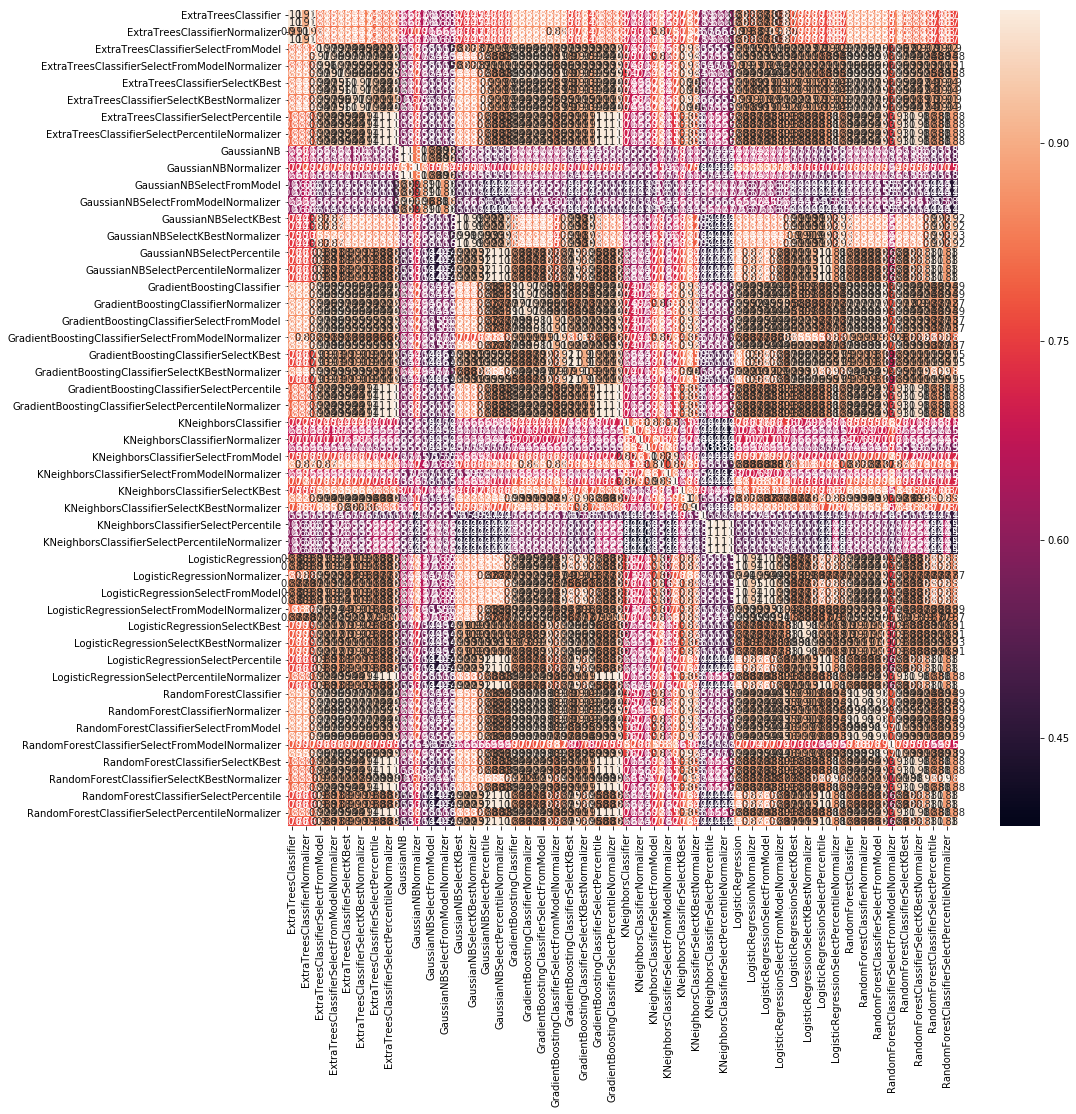

In [84]:
test_Survied = {}
for model_name in models:
    test_Survied[model_name] = pd.Series(models[model_name][scoring_refit].predict(test_X), name=model_name)

ensemble_results = pd.concat(test_Survied,axis=1)

fig, ax = plt.subplots(figsize=(15,15))
g= sns.heatmap(ensemble_results.corr(),annot=True, ax=ax)

# Ensemble Learning

In [85]:
ensemble_scores = {}
ensemble_evaluations = {}
ensemble_models = {}
ensemble_feature_selections = {}

## VotingClassifier

In [86]:
good_estimators = [
    'KNeighborsClassifierSelectFromModelRobustScaler',
    'ExtraTreesClassifierNormalizer',
    'GradientBoostingClassifierSelectFromModelNormalizer',
    'LogisticRegressionRobustScaler',
    'RandomForestClassifierSelectFromModelRobustScaler'
]
good_estimator_tuples = []
for estimator_name in good_estimators:
    good_estimator_tuples.append((estimator_name, clone(models[estimator_name][scoring_refit])))

In [87]:
estimators_permutations = list(itertools.combinations(good_estimator_tuples, 2))
estimators_permutations.extend(list(itertools.combinations(good_estimator_tuples, 3)))
estimators_permutations.extend(list(itertools.combinations(good_estimator_tuples, 4)))
estimators_permutations.extend(list(itertools.combinations(good_estimator_tuples, 5)))

In [88]:
last_length = 2
for estimators_permutation in estimators_permutations:
    name = ",".join(["".join([c for c in item[0] if c.isupper()]) for item in estimators_permutation])
    print(name, sep="- ", end=" ")
    model_vc = VotingClassifier(estimators = estimators_permutation, voting="soft")
    experiments = [    
        (name, model_vc),
    ]
    run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, ensemble_models, ensemble_evaluations, ensemble_feature_selections, ensemble_scores, cache_dirs)
    if len(estimators_permutation) > last_length:
        print(last_length)
    last_length = len(estimators_permutation)

KNCSFMRS,ETCN Fit KNCSFMRS,ETCN
model VotingClassifier
best_model VotingClassifier
KNCSFMRS,GBCSFMN Fit KNCSFMRS,GBCSFMN
model VotingClassifier
best_model VotingClassifier
KNCSFMRS,LRRS Fit KNCSFMRS,LRRS
model VotingClassifier
best_model VotingClassifier
KNCSFMRS,RFCSFMRS Fit KNCSFMRS,RFCSFMRS
model VotingClassifier
best_model VotingClassifier
ETCN,GBCSFMN Fit ETCN,GBCSFMN
model VotingClassifier
best_model VotingClassifier
ETCN,LRRS Fit ETCN,LRRS
model VotingClassifier
best_model VotingClassifier
ETCN,RFCSFMRS Fit ETCN,RFCSFMRS
model VotingClassifier
best_model VotingClassifier
GBCSFMN,LRRS Fit GBCSFMN,LRRS
model VotingClassifier
best_model VotingClassifier
GBCSFMN,RFCSFMRS Fit GBCSFMN,RFCSFMRS
model VotingClassifier
best_model VotingClassifier
LRRS,RFCSFMRS Fit LRRS,RFCSFMRS
model VotingClassifier
best_model VotingClassifier
KNCSFMRS,ETCN,GBCSFMN Fit KNCSFMRS,ETCN,GBCSFMN
model VotingClassifier
best_model VotingClassifier
2
KNCSFMRS,ETCN,LRRS Fit KNCSFMRS,ETCN,LRRS
model VotingClassif

## Evaluation of Ensemble Learning

In [89]:
show_group_evaluation(ensemble_evaluations, '', limit=10)

,group,type,test_recall_mean,test_recall_std,train_recall_mean,train_recall_std
12,"GBCSFMN,LRRS,RFCSFMRS","GBCSFMN,LRRS,RFCSFMRS",0.678571,0.050508,0.869048,0.036693
7,"KNCSFMRS,ETCN,RFCSFMRS","KNCSFMRS,ETCN,RFCSFMRS",0.678571,0.050508,0.839286,0.063554
20,"KNCSFMRS,LRRS,RFCSFMRS","KNCSFMRS,LRRS,RFCSFMRS",0.678571,0.058321,0.851190,0.060703
4,"ETCN,GBCSFMN,LRRS","ETCN,GBCSFMN,LRRS",0.678571,0.077152,0.851190,0.022272
5,"LRRS,RFCSFMRS","LRRS,RFCSFMRS",0.678571,0.077152,0.845238,0.055200
3,"KNCSFMRS,ETCN,LRRS","KNCSFMRS,ETCN,LRRS",0.678571,0.087482,0.839286,0.050508
18,"ETCN,LRRS,RFCSFMRS","ETCN,LRRS,RFCSFMRS",0.678571,0.087482,0.857143,0.050508
2,"ETCN,GBCSFMN,LRRS,RFCSFMRS","ETCN,GBCSFMN,LRRS,RFCSFMRS",0.666667,0.060703,0.869048,0.036693
14,"KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS","KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS",0.666667,0.060703,0.851190,0.046869
21,"KNCSFMRS,ETCN,LRRS,RFCSFMRS","KNCSFMRS,ETCN,LRRS,RFCSFMRS",0.666667,0.073386,0.845238,0.055200


,group,type,test_precision_mean,test_precision_std,train_precision_mean,train_precision_std
14,"KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS","KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS",0.795584,0.107863,0.883959,0.028041
20,"KNCSFMRS,LRRS,RFCSFMRS","KNCSFMRS,LRRS,RFCSFMRS",0.784713,0.118257,0.883406,0.016805
23,"KNCSFMRS,GBCSFMN,LRRS","KNCSFMRS,GBCSFMN,LRRS",0.784172,0.087782,0.879802,0.014922
11,"KNCSFMRS,RFCSFMRS","KNCSFMRS,RFCSFMRS",0.774896,0.099047,0.911496,0.018703
7,"KNCSFMRS,ETCN,RFCSFMRS","KNCSFMRS,ETCN,RFCSFMRS",0.772932,0.077434,0.882512,0.027385
5,"LRRS,RFCSFMRS","LRRS,RFCSFMRS",0.772670,0.090037,0.883566,0.025966
1,"GBCSFMN,RFCSFMRS","GBCSFMN,RFCSFMRS",0.768445,0.086152,0.907565,0.016374
3,"KNCSFMRS,ETCN,LRRS","KNCSFMRS,ETCN,LRRS",0.760369,0.103600,0.839818,0.017704
18,"ETCN,LRRS,RFCSFMRS","ETCN,LRRS,RFCSFMRS",0.760369,0.103600,0.886364,0.037625
25,"KNCSFMRS,LRRS","KNCSFMRS,LRRS",0.759453,0.110121,0.835128,0.023676


,group,type,test_accuracy_mean,test_accuracy_std,train_accuracy_mean,train_accuracy_std
14,"KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS","KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS",0.802523,0.034486,0.901309,0.017846
7,"KNCSFMRS,ETCN,RFCSFMRS","KNCSFMRS,ETCN,RFCSFMRS",0.802462,0.045330,0.896805,0.022467
20,"KNCSFMRS,LRRS,RFCSFMRS","KNCSFMRS,LRRS,RFCSFMRS",0.802402,0.050517,0.901294,0.019562
23,"KNCSFMRS,GBCSFMN,LRRS","KNCSFMRS,GBCSFMN,LRRS",0.798078,0.038786,0.903561,0.008695
5,"LRRS,RFCSFMRS","LRRS,RFCSFMRS",0.798018,0.033988,0.899057,0.016774
3,"KNCSFMRS,ETCN,LRRS","KNCSFMRS,ETCN,LRRS",0.793453,0.050534,0.878877,0.016830
18,"ETCN,LRRS,RFCSFMRS","ETCN,LRRS,RFCSFMRS",0.793453,0.050534,0.903561,0.015993
1,"GBCSFMN,RFCSFMRS","GBCSFMN,RFCSFMRS",0.789129,0.023808,0.921473,0.023038
12,"GBCSFMN,LRRS,RFCSFMRS","GBCSFMN,LRRS,RFCSFMRS",0.789069,0.028784,0.910288,0.020871
11,"KNCSFMRS,RFCSFMRS","KNCSFMRS,RFCSFMRS",0.789069,0.051524,0.910288,0.008674


,group,type,test_f1_mean,test_f1_std,train_f1_mean,train_f1_std
20,"KNCSFMRS,LRRS,RFCSFMRS","KNCSFMRS,LRRS,RFCSFMRS",0.723339,0.062041,0.865612,0.030939
7,"KNCSFMRS,ETCN,RFCSFMRS","KNCSFMRS,ETCN,RFCSFMRS",0.722188,0.059757,0.858695,0.034857
14,"KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS","KNCSFMRS,GBCSFMN,LRRS,RFCSFMRS",0.718599,0.036989,0.866215,0.026057
5,"LRRS,RFCSFMRS","LRRS,RFCSFMRS",0.716536,0.044362,0.862466,0.026600
3,"KNCSFMRS,ETCN,LRRS","KNCSFMRS,ETCN,LRRS",0.712219,0.069541,0.838608,0.026302
18,"ETCN,LRRS,RFCSFMRS","ETCN,LRRS,RFCSFMRS",0.712219,0.069541,0.869708,0.022994
23,"KNCSFMRS,GBCSFMN,LRRS","KNCSFMRS,GBCSFMN,LRRS",0.709517,0.050816,0.870338,0.015820
12,"GBCSFMN,LRRS,RFCSFMRS","GBCSFMN,LRRS,RFCSFMRS",0.708499,0.029893,0.879460,0.027901
21,"KNCSFMRS,ETCN,LRRS,RFCSFMRS","KNCSFMRS,ETCN,LRRS,RFCSFMRS",0.705011,0.066755,0.864969,0.021611
2,"ETCN,GBCSFMN,LRRS,RFCSFMRS","ETCN,GBCSFMN,LRRS,RFCSFMRS",0.700114,0.041663,0.873921,0.021269


In [90]:
show_scores(ensemble_scores, '', limit=10)

,model_name,train,test
2,"ETCN,GBCSFMN,LRRS,RFCSFMRS",0.853293,0.860987
3,"KNCSFMRS,ETCN,LRRS",0.854790,0.860987
17,"ETCN,GBCSFMN,RFCSFMRS",0.857784,0.860987
16,"KNCSFMRS,ETCN,GBCSFMN,RFCSFMRS",0.863772,0.860987
13,"KNCSFMRS,ETCN,GBCSFMN,LRRS,RFCSFMRS",0.857784,0.856502
23,"KNCSFMRS,GBCSFMN,LRRS",0.859281,0.856502
19,"ETCN,GBCSFMN",0.860778,0.856502
10,"KNCSFMRS,ETCN,GBCSFMN,LRRS",0.854790,0.856502
24,"KNCSFMRS,ETCN",0.856287,0.852018
6,"KNCSFMRS,GBCSFMN,RFCSFMRS",0.865269,0.852018


# Deployment

In [91]:
ensemble_models['KNCSFMRS,ETCN,GBCSFMN,RFCSFMRS'][scoring_refit]

VotingClassifier(estimators=(('KNeighborsClassifierSelectFromModelRobustScaler', Pipeline(memory=Memory(cachedir='/tmp/tmpv57gzg18/joblib'),
     steps=[('reduce_dim', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_ite...ators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]))),
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [92]:
test_Y = ensemble_models['KNCSFMRS,ETCN,GBCSFMN,RFCSFMRS'][scoring_refit].predict( test_X )
passenger_id = combined_df[891:].PassengerId
prediction = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
prediction.Survived = prediction.Survived.astype(int)
prediction.shape
print(prediction.head())
prediction.to_csv( 'titanic_prediction.csv' , index = False )

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


In [93]:
output = pd.read_csv('titanic_prediction.csv')
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [94]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "."]).decode("utf8"))
print(check_output(["ls", ".."]).decode("utf8"))

test.csv
train.csv

titanic_prediction.csv
titanic-starter.ipynb

21 - Titanic
22 - House Pricing
input



In [95]:
end = time.time()
print("Analysis took %0.2f seconds to train"%(end - start))

Analysis took 2317.25 seconds to train
